In [100]:
nombre = '20241023'

In [ ]:
free_memory()

Memory freed!


# Install

In [1]:
# !pip install pyvolutionary==2.4.2
# !pip install scikit_learn==1.4
!pip install pycaret
!pip install pycaret[full]
!pip install nlpaug==1.1.11
!pip install imbalanced-learn==0.11.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 51.8 MB/s eta 0:00:00
   ━━

# Preload

In [101]:
import warnings
warnings.filterwarnings("ignore",category=FutureWarning)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from numpy.linalg import svd
import requests
import json


sscaler = StandardScaler()
rscaler = RobustScaler()
mmscaler = MinMaxScaler()
mascaler = MaxAbsScaler()

le = LabelEncoder()

def lencoder(df, col, lenc=False, train=True):
    if train:
        label = le.fit_transform(df[col])
        df[col] = pd.to_numeric(label)
        return df,le
    elif lenc != False:
        label = lenc.transform(df[col])
        df[col] = pd.to_numeric(label)
        return df
    else:
        print('Nothing done')
        return df



In [102]:
def run_kfold_model (model, X,y,K=10,graph=True):
    regr = LinearRegression()
    kf = KFold(n_splits=5)
    s=1
    for train_index, test_index in kf.split(X):
        # print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        print('Slice '+str(s)+' score: '+str(regr.score(X_test, y_test)))
        y_pred = model.predict(X_test)
        scores(y_test, y_pred)
        if graph:
            plt.scatter(y_test, y_pred, color = 'red', marker = 'o', s = 35, alpha = 0.5, label = 'Test data')
            plt.show()
        s+=1
    return(regr)

In [103]:
# def scores (model, X_train, X_test, y_test, y_pred, graph=True):
#     MAE=metrics.mean_absolute_error(y_test, y_pred)
#     MSE=metrics.mean_squared_error(y_test, y_pred)
#     RMSE=np.sqrt(metrics.mean_squared_error(y_test, y_pred))
#     CV_RMSE= (RMSE/np.average(y_test))*100
#     R2=metrics.r2_score(y_test, y_pred)
#     ACC=metrics.accuracy_score
#     REC=metrics.recall_score
#     PREC=metrics.precision_score

#     print('MAE:'+str(MAE))
#     print('MSE:'+str(MSE))
#     print('RMSE:'+str(RMSE))
#     print('CV(RMSE): '+str(CV_RMSE))
#     print('R2:'+str(R2))
#     print('Accuracy:'+str(ACC))
#     print('Recall:'+str(REC))
#     print('Precision:'+str(PREC))

#     # print('Training score: '+str(model.score(X_train, y_train))) #(Accuracy or R2)
#     # print('Test score: '+str(model.score(X_test, y_train)))
#     if graph == True:
#         plt.scatter(y_train, y_pred, color = 'red', marker = 'o', s = 35, alpha = 0.5, label = 'Test data')
#         plt.show()

In [104]:
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, cohen_kappa_score, matthews_corrcoef

def scores(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # Recall
    recall = recall_score(y_test, y_pred,average='weighted')
    print("Recall:", recall)

    # Precision
    precision = precision_score(y_test, y_pred,average='weighted')
    print("Precision:", precision)

    # F1 Score
    f1 = f1_score(y_test, y_pred,average='weighted')
    print("F1 Score:", f1)

    # Cohen's Kappa
    kappa = cohen_kappa_score(y_test, y_pred)
    print("Cohen's Kappa:", kappa)

    # Matthews Correlation Coefficient (MCC)
    mcc = matthews_corrcoef(y_test, y_pred)
    print("MCC:", mcc)


In [105]:
import dask.dataframe as dd

In [106]:
from ast import literal_eval
def clean(x):
    return literal_eval(x)

In [107]:
pd.set_option("mode.copy_on_write", True)
pd.options.mode.copy_on_write = True

In [108]:
import math

def dummies(df, col):
    tDummy = pd.get_dummies(df[col]).add_prefix(col+'_')
    df = pd.concat([df,tDummy],axis=1).reindex(df.index)
    return(df)

def just_dummies(df, col):
    tDummy = pd.get_dummies(df[col]).add_prefix(col+'_')
    return(tDummy)

def just_dummies_steps(df, col, ix):
    num_chunks = math.ceil(len(df) / ix)  # Calculate number of chunks
    all_dummies = []  # Store results from each chunk

    for i in range(num_chunks):
        start = i * ix  # Starting index for the current chunk
        end = (i + 1) * ix  # Ending index for the current chunk

        chunk = df.loc[start:end-1] # Select chunk of data for the dummies
        chunk_dummies = just_dummies(chunk, col)  # Apply just_dummies to chunk
        all_dummies.append(chunk_dummies)  # Append the output to the list

    # Concatenate all dummy DataFrames horizontally
    final_dummies = pd.concat(all_dummies, axis=1)
    return final_dummies

In [109]:
def columns_with_nan(df):
    # Obtener una lista de los nombres de las columnas
    columns = df.columns.to_list()

    # Filtrar las columnas que tienen valores NaN
    columns_with_nan = [col for col in columns if df[col].isna().any()]

    return columns_with_nan

def rows_with_nan(df, column_name):
    # Filtrar las filas donde la columna especificada tiene valores NaN
    rows_with_nan = df[df[column_name].isna()]
    return rows_with_nan

In [110]:
import gc

def free_memory():
    # Variables used in initial data loading and NLP
    variables_to_delete = [
        'data', 'exploded', 'exploded_filtered', 'checkit', 'checkot', 'checket',
        'wordlst', 'over1', 'tfidf_Psummary', 'tfidf_Pdescription', 'mwe_tokenizer',
        'tokenizer', 'stop_words', 'lemmatizer', 'text', 'tokenised',
        'retokenised', 'normalised', 'unmarked', 'filtered', 'lemmatised'
    ]

    # Variables used for model training and evaluation
    variables_to_delete.extend([
        'dataHM', 'datarf',  'dataset', 'X', 'Y', 'X_train', 'X_test',
        'y_train', 'y_test', 'dtrain', 'dtest', 'output', 'y_pred',
        'clf1', 'best_model', 'tuned_model', 'model', 'rf_model',
        'params', 'accuracy', 'grid_search',  'evolution', 'result',
        'ros', 'X_ros', 'y_ros', 'rus', 'X_rus', 'y_rus', 'smote', 'X_smote',
        'y_smote', 'adasyn', 'X_adasyn', 'y_adasyn', 'smoteenn', 'X_smoteenn',
        'y_smoteenn', 'class_names','correlations','selected_features'
    ])


    # Delete the variables
    for var in variables_to_delete:
        if var in globals():  # Check if variable exists
            del globals()[var]

    # Run garbage collection
    gc.collect()

    print("Memory freed!")

# Checkpoint 1 Get data

In [ ]:
# data = pd.read_excel('mozilla-bugs-all.xlsx')
# data.describe

In [ ]:
def json_data(URL,params):
    headers = {"Accept" : "application/json"}
    resp = requests.get(URL, params= params, headers= headers)
    df = pd.DataFrame()
    if resp.status_code != 200:
        print('error: ' + str(resp.status_code))
    else:
        print('Success')
        bugs = resp.text
        data = json.loads(bugs)
        df = pd.json_normalize(data['bugs'])
    return(df)

params ={
    "include_fields" : ["id"
                        ,"summary"
                        ,"status"
                        ,"description"
                        ,"type"
                        ,"classification"
                        ,"product"
                        ,"component"
                        ,"priority"
                        ,"assigned_to"
                        ,"resolution"
                        ,"creation_time"
                        ,"last_change_time"
                        ,"severity"
                        ,"version"
                        ]
    ,"product" : "Core"
    ,"severity" : ["S1"]
    # ,"status" : ["VERIFIED","RESOLVED","CLOSED","UNCONFIRMED","NEW"]
    ,"limit" : 1000
    ,"order": "opendate DESC"
}
URL = "https://bugzilla.mozilla.org/rest/bug"


In [ ]:
params["status"] = "RESOLVED"
params.pop("status", None)

test_df = json_data(URL,params)
print(test_df.columns.to_list())
test_df.tail()

Success
['priority', 'version', 'last_change_time', 'assigned_to', 'description', 'severity', 'classification', 'summary', 'status', 'product', 'creation_time', 'id', 'component', 'resolution', 'type', 'assigned_to_detail.email', 'assigned_to_detail.real_name', 'assigned_to_detail.id', 'assigned_to_detail.nick', 'assigned_to_detail.name']


,priority,version,last_change_time,assigned_to,description,severity,classification,summary,status,product,creation_time,id,component,resolution,type,assigned_to_detail.email,assigned_to_detail.real_name,assigned_to_detail.id,assigned_to_detail.nick,assigned_to_detail.name
190,P1,unspecified,2020-05-18T19:14:56Z,docfaraday@gmail.com,This bug is for crash report bp-357d3ef4-a78d-...,S1,Components,Crash in [@ mozilla::MozPromise<T>::Private::R...,VERIFIED,Core,2020-05-08T22:47:46Z,1636615,Audio/Video: Playback,FIXED,defect,docfaraday@gmail.com,Byron Campen [:bwc],478411,bwc,docfaraday@gmail.com
191,P2,78 Branch,2020-07-15T02:09:47Z,nobody@mozilla.org,User Agent: Mozilla/5.0 (Macintosh; Intel Mac ...,S1,Components,meet.google.com takes 10 seconds until others ...,RESOLVED,Core,2020-05-08T22:42:53Z,1636614,WebRTC: Audio/Video,FIXED,defect,nobody@mozilla.org,Nobody; OK to take it and work on it,1,nobody,nobody@mozilla.org
192,P1,76 Branch,2020-06-29T21:02:04Z,nobody@mozilla.org,User Agent: Mozilla/5.0 (Windows NT 10.0; Win6...,S1,Components,nsIPKCS11ModuleDB.addModule failure in 76+ (Es...,RESOLVED,Core,2020-05-07T12:32:32Z,1636100,Security: PSM,DUPLICATE,defect,nobody@mozilla.org,Nobody; OK to take it and work on it,1,nobody,nobody@mozilla.org
193,--,75 Branch,2020-06-17T07:11:27Z,zibi@braniecki.net,User Agent: Mozilla/5.0 (Macintosh; Intel Mac ...,S1,Components,Context menus are blank on macOS,RESOLVED,Core,2020-04-11T17:56:55Z,1629291,Internationalization,FIXED,defect,zibi@braniecki.net,Zibi Braniecki [:zbraniecki][:gandalf],41270,zbraniecki,zibi@braniecki.net
194,P1,unspecified,2022-04-18T19:22:12Z,acreskey@mozilla.com,While looking at profiles generated as part of...,S1,Components,Determine if we are indeed spending up to 3x a...,RESOLVED,Core,2019-09-23T18:20:19Z,1583298,Performance,WORKSFORME,task,acreskey@mozilla.com,Andrew Creskey [:acreskey],624474,acreskey,acreskey@mozilla.com


In [ ]:
# for i in test_df.columns.to_list():
#     print("Column "+i+" unique values:")
#     # print(test_df[i].unique())
#     print(test_df[i].value_counts())

#     print()


In [ ]:
# test_df.groupby(['resolution']).sum().plot(kind='pie', y='id', autopct='%1.0f%%', labeldistance=None)
# from datetime import datetime
import csv

# print(test_df['creation_time'].min())
# datetime.now() - pd.to_datetime(pd.to_datetime(test_df['creation_time'][test_df['resolution']=='FIXED']).values.astype(np.int64).mean())
# plt.pie(x=test_df['resolution'].unique(), labels=test_df['resolution'].value_counts())
# plt.show()

# plt.title('Category Distribution')
# plt.ylabel('')  # Hide the y-label
# plt.show()

# test_df.to_csv("dataset_20241023.csv")
test_df.to_csv("dataset_"+nombre+".csv", escapechar='\\', quoting=csv.QUOTE_NONNUMERIC)


# test_df.date = pd.to_datetime(test_df.date).values.astype(np.int64)

# test_df = pd.DataFrame(pd.to_datetime(test_df.groupby('column').mean().date))

# Checkpoint 2 NLP

In [12]:
data = pd.read_csv('dataset_'+nombre+'.csv', index_col = 'id')
unnamed_cols = [col for col in data.columns if col.startswith('Unnamed')]
data = data.drop(unnamed_cols,axis=1)
unnamed_cols = [col for col in data.columns if col.startswith('index')]
data = data.drop(unnamed_cols,axis=1)
data.index.name = 'id'
data.head()

,assigned_to,assigned_to_detail.email,assigned_to_detail.id,assigned_to_detail.name,assigned_to_detail.nick,assigned_to_detail.real_name,classification,component,creation_time,description,last_change_time,priority,product,resolution,severity,status,summary,type,version,nid
id,,,,,,,,,,,,,,,,,,,,
1809860,apehrson@mozilla.com,apehrson@mozilla.com,489889,apehrson@mozilla.com,pehrsons,Andreas Pehrson [:pehrsons],Components,WebRTC: Audio/Video,2023-01-12T11:00:08Z,"3 crashes from 2 installations, both macOS Fir...",2023-01-20T13:42:32Z,P1,Core,FIXED,S2,VERIFIED,Crash in [@ mozilla::Maybe<T>::emplace<T> | we...,defect,unspecified,0
1809985,alwu@mozilla.com,alwu@mozilla.com,517691,alwu@mozilla.com,alwu,Alastor Wu [:alwu],Components,Audio/Video: Playback,2023-01-12T19:18:35Z,This will be wmfme only test.,2023-01-18T09:58:01Z,P2,Core,FIXED,S2,RESOLVED,[wmfme] add test for bug 1808804 and create br...,task,unspecified,1
1810396,azebrowski@mozilla.com,azebrowski@mozilla.com,700434,azebrowski@mozilla.com,az,az [:az],Components,Audio/Video: Playback,2023-01-16T07:44:18Z,Crash report: https://crash-stats.mozilla.org/...,2023-06-14T16:36:00Z,P2,Core,FIXED,S2,RESOLVED,Crash in [@ mozilla::CheckedInt<T>::value],defect,unspecified,2
1810421,davidp99@gmail.com,davidp99@gmail.com,506442,davidp99@gmail.com,handyman,David Parks [:handyman],Components,Widget: Win32,2023-01-16T10:21:37Z,User Agent: Mozilla/5.0 (Windows NT 10.0; Win6...,2023-09-02T02:24:07Z,P2,Core,FIXED,S2,RESOLVED,Lag spikes every 5-6 seconds when Windows Loca...,defect,Firefox 108,3
1810536,valentin.gosu@gmail.com,valentin.gosu@gmail.com,415378,valentin.gosu@gmail.com,valentin,Valentin Gosu [:valentin] (he/him) {{ PTO unti...,Components,Networking: HTTP,2023-01-16T14:33:49Z,According to this [search](https://crash-stats...,2023-10-18T03:37:21Z,P1,Core,FIXED,S2,RESOLVED,Crashes in Http/3 code,defect,unspecified,4


In [13]:
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import MWETokenizer
from nltk.stem import WordNetLemmatizer
import nlpaug.augmenter.word as naw
import math
import re

def NLProcess (text):

    # print('Original text: ',data.iloc[1]['description'])
    #print("====================== starting ======================")
    ######################################################################### Tokenised
    mwe_tokenizer = MWETokenizer([('does', 'not'), ('in', 'spite', 'of'),('don', '’', 't')])
    tokenizer = word_tokenize
    tokenised = tokenizer(text)
    #print('Tokenised: ',tokenised)
    retokenised = mwe_tokenizer.tokenize(tokenised)
    # retokenised = [token.replace('_', '') for token in retokenised]
    #print('ReTokenised: ',retokenised)

    ######################################################################### Lower-case converted
    normalised = [word.lower() for word in retokenised]
    #print('Normalised: ',normalised)

    ######################################################################### Punctuation marks removed
    unmarked = [re.sub(r'[^\w\s]', '', token) for token in normalised if re.sub(r'[^\w\s]', '', token)]
    #print('Punctuation marks removed: ',unmarked)

    ######################################################################### Stop-words removed
    stop_words = set(stopwords.words('english'))
    filtered = [word for word in unmarked if word not in stop_words]
    #print('Stop-words removed: ',filtered)

    ######################################################################### Lemmatised
    lemmatizer = WordNetLemmatizer()
    lemmatised = [lemmatizer.lemmatize(word) for word in filtered]
    #print('Lemmatised: ',lemmatised)

    ######################################################################### Augmented
    # aug = naw.SynonymAug(aug_src='wordnet')
    # augmented = [aug.augment(word) for word in lemmatised]
    # augmented = [item for sublist in augmented for item in sublist] #flattening here
    # #print('Augmented: ',augmented)

    return lemmatised


In [15]:
# def dfNLProcess (df,column):
#     for index, row in df.iterrows():
#         text = row[column]
#         # print('Original text: ',data.iloc[1]['description'])
#         #print("====================== starting ======================")
#         ######################################################################### Tokenised
#         mwe_tokenizer = MWETokenizer([('does', 'not'), ('in', 'spite', 'of'),('don', '’', 't')])
#         tokenizer = word_tokenize
#         tokenised = tokenizer(text)
#         #print('Tokenised: ',tokenised)
#         retokenised = mwe_tokenizer.tokenize(tokenised)
#         # retokenised = [token.replace('_', '') for token in retokenised]
#         #print('ReTokenised: ',retokenised)

#         ######################################################################### Lower-case converted
#         normalised = [word.lower() for word in retokenised]
#         #print('Normalised: ',normalised)

#         ######################################################################### Punctuation marks removed
#         unmarked = [re.sub(r'[^\w\s]', '', token) for token in normalised if re.sub(r'[^\w\s]', '', token)]
#         #print('Punctuation marks removed: ',unmarked)

#         ######################################################################### Stop-words removed
#         stop_words = set(stopwords.words('english'))
#         filtered = [word for word in unmarked if word not in stop_words]
#         #print('Stop-words removed: ',filtered)

#         ######################################################################### Lemmatised
#         lemmatizer = WordNetLemmatizer()
#         lemmatised = [lemmatizer.lemmatize(word) for word in filtered]
#         #print('Lemmatised: ',lemmatised)

#         lemmatised
#         ncol = 'P'+col
#         df2 = pd.DataFrame({ncol:lemmatised})
#         df2 = dummies(df2)


In [16]:
# dfNLProcess(data,'summary')

In [17]:
# for i in range(10):
#     NLProcess(data.iloc[i]['description'])

data['Psummary'] = data['summary'].map(NLProcess)

# type(data['summary'])

In [18]:
# data['Pdescription'] = data['description'].fillna('').map(NLProcess)

In [19]:
#data.loc[data['description'].str.contains('//crash-stats.mozilla.org/report/index/768c5c44-57c5-4746-890c-9af820240811', case=False, na=False)]

In [20]:
data.head()

,assigned_to,assigned_to_detail.email,assigned_to_detail.id,assigned_to_detail.name,assigned_to_detail.nick,assigned_to_detail.real_name,classification,component,creation_time,description,...,priority,product,resolution,severity,status,summary,type,version,nid,Psummary
id,,,,,,,,,,,,,,,,,,,,,
1809860,apehrson@mozilla.com,apehrson@mozilla.com,489889,apehrson@mozilla.com,pehrsons,Andreas Pehrson [:pehrsons],Components,WebRTC: Audio/Video,2023-01-12T11:00:08Z,"3 crashes from 2 installations, both macOS Fir...",...,P1,Core,FIXED,S2,VERIFIED,Crash in [@ mozilla::Maybe<T>::emplace<T> | we...,defect,unspecified,0,"[crash, mozilla, maybe, emplace, webrtc, video..."
1809985,alwu@mozilla.com,alwu@mozilla.com,517691,alwu@mozilla.com,alwu,Alastor Wu [:alwu],Components,Audio/Video: Playback,2023-01-12T19:18:35Z,This will be wmfme only test.,...,P2,Core,FIXED,S2,RESOLVED,[wmfme] add test for bug 1808804 and create br...,task,unspecified,1,"[wmfme, add, test, bug, 1808804, create, brows..."
1810396,azebrowski@mozilla.com,azebrowski@mozilla.com,700434,azebrowski@mozilla.com,az,az [:az],Components,Audio/Video: Playback,2023-01-16T07:44:18Z,Crash report: https://crash-stats.mozilla.org/...,...,P2,Core,FIXED,S2,RESOLVED,Crash in [@ mozilla::CheckedInt<T>::value],defect,unspecified,2,"[crash, mozilla, checkedint, value]"
1810421,davidp99@gmail.com,davidp99@gmail.com,506442,davidp99@gmail.com,handyman,David Parks [:handyman],Components,Widget: Win32,2023-01-16T10:21:37Z,User Agent: Mozilla/5.0 (Windows NT 10.0; Win6...,...,P2,Core,FIXED,S2,RESOLVED,Lag spikes every 5-6 seconds when Windows Loca...,defect,Firefox 108,3,"[lag, spike, every, 56, second, window, locati..."
1810536,valentin.gosu@gmail.com,valentin.gosu@gmail.com,415378,valentin.gosu@gmail.com,valentin,Valentin Gosu [:valentin] (he/him) {{ PTO unti...,Components,Networking: HTTP,2023-01-16T14:33:49Z,According to this [search](https://crash-stats...,...,P1,Core,FIXED,S2,RESOLVED,Crashes in Http/3 code,defect,unspecified,4,"[crash, http3, code]"


In [21]:
data = data.reset_index()
data.to_csv("dataset_"+nombre+"_plusP.csv")

# Checkpoint 3 Psummary

In [22]:
data = pd.read_csv('dataset_'+nombre+'_plusP.csv', converters={'Psummary': clean}, index_col = 'id') #
unnamed_cols = [col for col in data.columns if col.startswith('Unnamed')]
data = data.drop(unnamed_cols,axis=1)
data.index.name = 'id'
data.tail()

,assigned_to,assigned_to_detail.email,assigned_to_detail.id,assigned_to_detail.name,assigned_to_detail.nick,assigned_to_detail.real_name,classification,component,creation_time,description,...,priority,product,resolution,severity,status,summary,type,version,nid,Psummary
id,,,,,,,,,,,,,,,,,,,,,
11021,alwu@mozilla.com,alwu@mozilla.com,517691,alwu@mozilla.com,alwu,Alastor Wu [:alwu],Components,Audio/Video: Playback,2024-08-02T12:18:18Z,**Found in**\n* 129.0 RC2\n\n**Affected versio...,...,P1,Core,FIXED,S1,VERIFIED,[Windows] Videos on Hulu fail to play,defect,Trunk,11021,"[window, video, hulu, fail, play]"
11022,tziade@mozilla.com,tziade@mozilla.com,385707,tziade@mozilla.com,tarek,Tarek Ziadé (:tarek),Components,Machine Learning,2024-08-05T07:15:57Z,I tried the feature in a beta simul and it fai...,...,P1,Core,FIXED,S1,RESOLVED,ML Fails in non-debug mode because of maxLogLe...,defect,unspecified,11022,"[ml, fails, nondebug, mode, maxloglevelpref]"
11023,earo@mozilla.com,earo@mozilla.com,318883,earo@mozilla.com,eemeli,Eemeli Aro [:eemeli],Components,Internationalization,2024-09-06T07:12:19Z,The earlier update of the `unic-langid` and `u...,...,P1,Core,FIXED,S1,VERIFIED,Browser considers Saraiki (skr) as LTR rather ...,defect,Firefox 130,11023,"[browser, considers, saraiki, skr, ltr, rather..."
11024,alwu@mozilla.com,alwu@mozilla.com,517691,alwu@mozilla.com,alwu,Alastor Wu [:alwu],Components,Audio/Video: Playback,2024-09-20T15:34:31Z,Setup:\n- Have `media.wmf.media-engine.enabled...,...,P1,Core,FIXED,S1,RESOLVED,Hulu is not playing in Nightly on Windows Machine,defect,unspecified,11024,"[hulu, playing, nightly, window, machine]"
11025,sotaro.ikeda.g@gmail.com,sotaro.ikeda.g@gmail.com,434202,sotaro.ikeda.g@gmail.com,sotaro,Sotaro Ikeda [:sotaro],Components,Graphics,2024-10-02T14:23:09Z,User Agent: Mozilla/5.0 (Windows NT 10.0; Win6...,...,P1,Core,FIXED,S1,VERIFIED,VR180 and 360 YouTube videos not working in Fi...,defect,Firefox 131,11025,"[vr180, 360, youtube, video, working, firefox,..."


In [23]:
# from sklearn.feature_selection import mutual_info_classif

In [24]:
type(data.iloc[0]['Psummary'])
# type(data['Psummary'])

list

In [25]:
exploded = data.explode('Psummary')#.explode('Psummary')

In [26]:
filter=r'^\d+$'
notfilter=r'^(?!'+filter.replace('^','')+').*$'
mask = exploded['Psummary'].str.contains(notfilter, regex=True)
exploded_filtered = exploded.loc[mask]
# exploded_filtered = exploded.loc[exploded['Psummary'].str.contains(notfilter)]

In [27]:
checkit = just_dummies(exploded_filtered,'Psummary')

In [28]:
checkit = dd.from_pandas(checkit, chunksize=100)

In [29]:
checkit.head()

,Psummary_00f,Psummary_00svg,Psummary_01f,Psummary_0a1,Psummary_0async,Psummary_0cad754da2ee3ececcfa1aad8b858a0286c24e16,Psummary_0kb,Psummary_0n,Psummary_0pct,Psummary_0px,...,Psummary_zoomed,Psummary_zooming,Psummary_zoomingpanning,Psummary_zoomletterspacinghtml,Psummary_zoomtext,Psummary_zstd,Psummary_zwp_pointer_gestures_v1,Psummary_zwp_tablet_tool_v2_set_cursor,Psummary_zwsetevent,Psummary_ñ
id,,,,,,,,,,,,,,,,,,,,,
10831,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10831,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10831,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10831,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10831,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [30]:
# prefix='Psummary_'
# filter=prefix+'\d+$'
# notfilter='^(?!'+filter+').*$'
# print(len(checkit.filter(regex=(notfilter)).columns.tolist()))
# # print(checkit.filter(regex=(notfilter)).columns.tolist())

In [31]:
checkot = checkit.groupby(['id'], observed=True).sum()

In [32]:
checkot['nid'] = checkot.index

In [33]:
# checkot.head()

In [34]:
checket = checkot.compute()

In [35]:
checkit = checket.copy()
checkit = checkit.reset_index()

In [36]:
checkit.head()

,id,Psummary_00f,Psummary_00svg,Psummary_01f,Psummary_0a1,Psummary_0async,Psummary_0cad754da2ee3ececcfa1aad8b858a0286c24e16,Psummary_0kb,Psummary_0n,Psummary_0pct,...,Psummary_zooming,Psummary_zoomingpanning,Psummary_zoomletterspacinghtml,Psummary_zoomtext,Psummary_zstd,Psummary_zwp_pointer_gestures_v1,Psummary_zwp_tablet_tool_v2_set_cursor,Psummary_zwsetevent,Psummary_ñ,nid
0,1917215,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1917215
1,1855967,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1855967
2,1861267,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1861267
3,1914347,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1914347
4,1914430,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1914430


In [37]:
# def rowgroupbyidnex(df):
#     rows = []
#     for i in len(df):
#         rows.append(df.iloc[i].groupby(checkit.index, observed=True).sum())





In [38]:
checkit.to_csv('dataset_'+nombre+'_plusP_Psummary.csv')

# Checkpoint 4 Out of order

In [ ]:
data = pd.read_csv('dataset_'+nombre+'_plusP.csv', converters={'Pdescription': clean,'Psummary': clean})
unnamed_cols = [col for col in data.columns if col.startswith('Unnamed')]
data = data.drop(unnamed_cols,axis=1)
data.index.name = 'id'
data.head()

,id,severity,resolution,assigned_to,type,creation_time,status,component,priority,version,...,classification,description,summary,product,assigned_to_detail.nick,assigned_to_detail.id,assigned_to_detail.name,assigned_to_detail.email,assigned_to_detail.real_name,Psummary
id,,,,,,,,,,,,,,,,,,,,,
0,1926480,--,NaN,dpalmeiro@mozilla.com,defect,2024-10-23T03:05:31Z,NEW,JavaScript Engine,--,unspecified,...,Components,IonFreeTasks cause a lot of malloc lock conten...,Consider scheduling IonFreeTask's during Idle ...,Core,denispal,621440,dpalmeiro@mozilla.com,dpalmeiro@mozilla.com,Denis Palmeiro [:denispal],"[reckon, schedule, ionfreetask, out of work, m..."
1,1926478,--,NaN,nobody@mozilla.org,defect,2024-10-23T02:49:35Z,NEW,JavaScript Engine: JIT,--,unspecified,...,Components,A lot of time spent under malloc trying to gro...,"Too much time in SetElementMegamorphic for ""co...",Core,nobody,1,nobody@mozilla.org,nobody@mozilla.org,Nobody; OK to take it and work on it,"[much, meter, setelementmegamorphic, completew..."
2,1926477,--,NaN,nobody@mozilla.org,defect,2024-10-23T02:32:21Z,NEW,JavaScript Engine: JIT,--,unspecified,...,Components,We are 3x slower than Chrome for the function ...,Calling the getter in js::jit::GetPropertyCach...,Core,nobody,1,nobody@mozilla.org,nobody@mozilla.org,Nobody; OK to take it and work on it,"[ring, getter, joule, jit, getpropertycached, ..."
3,1926476,--,NaN,wptsync@mozilla.bugs,task,2024-10-23T02:31:19Z,NEW,Audio/Video: Web Codecs,P4,unspecified,...,Components,Sync web-platform-tests PR 48766 into mozilla-...,[wpt-sync] Sync PR 48766 - Bump maximum video ...,Core,wpt-sync,611017,wptsync@mozilla.bugs,wptsync@mozilla.bugs,Web Platform Test Sync Bot [:wpt-sync] (Matrix...,"[wptsync, sync, praseodymium, 48766, jut, uppe..."
4,1926474,--,NaN,nobody@mozilla.org,defect,2024-10-23T02:17:01Z,NEW,JavaScript Engine,--,unspecified,...,Components,Inflating the strings to UTF16 is causing a lo...,Inflating strings during JSRope::flatten is ca...,Core,nobody,1,nobody@mozilla.org,nobody@mozilla.org,Nobody; OK to take it and work on it,"[inflate, drawstring, jsrope, flatten, make, m..."


In [ ]:
exploded = data.explode('Pdescription')
filter='^\d+$'
notfilter='^(?!'+filter+').*$'

exploded = exploded.loc[exploded['Pdescription'].notna()]

exploded_filtered = exploded.loc[exploded['Pdescription'].str.contains(notfilter)]

KeyError: 'Pdescription'

In [ ]:
exploded_filtered['nindex'] = exploded_filtered.index

In [ ]:
exploded_filtered = exploded_filtered.reset_index()

In [ ]:
checkit = just_dummies_steps(exploded_filtered[['nindex','Pdescription']],'Pdescription',1000)

In [ ]:
checkit = dd.from_pandas(checkit, chunksize=100)

In [ ]:
checkot = checkit.groupby([checkit.index], observed=True).sum()
checkot['nindex'] = checkot.index
checket = checkot.compute()
checkit = checket.reset_index()
checkit.to_csv('dataset_'+nombre+'_plusP_Pdescription.csv')

# Checkpoint 5 TFIDF

In [14]:
data = pd.read_csv('dataset_'+nombre+'_plusP.csv', converters={'Psummary': clean}, index_col='id') #it comes out of step 2 and it's NLP
unnamed_cols = [col for col in data.columns if col.startswith('Unnamed')]
data = data.drop(unnamed_cols,axis=1)
data.index.name = 'id'
data.head()

,assigned_to,assigned_to_detail.email,assigned_to_detail.id,assigned_to_detail.name,assigned_to_detail.nick,assigned_to_detail.real_name,classification,component,creation_time,description,...,priority,product,resolution,severity,status,summary,type,version,nid,Psummary
id,,,,,,,,,,,,,,,,,,,,,
1809860,apehrson@mozilla.com,apehrson@mozilla.com,489889,apehrson@mozilla.com,pehrsons,Andreas Pehrson [:pehrsons],Components,WebRTC: Audio/Video,2023-01-12T11:00:08Z,"3 crashes from 2 installations, both macOS Fir...",...,P1,Core,FIXED,S2,VERIFIED,Crash in [@ mozilla::Maybe<T>::emplace<T> | we...,defect,unspecified,0,"[crash, mozilla, maybe, emplace, webrtc, video..."
1809985,alwu@mozilla.com,alwu@mozilla.com,517691,alwu@mozilla.com,alwu,Alastor Wu [:alwu],Components,Audio/Video: Playback,2023-01-12T19:18:35Z,This will be wmfme only test.,...,P2,Core,FIXED,S2,RESOLVED,[wmfme] add test for bug 1808804 and create br...,task,unspecified,1,"[wmfme, add, test, bug, 1808804, create, brows..."
1810396,azebrowski@mozilla.com,azebrowski@mozilla.com,700434,azebrowski@mozilla.com,az,az [:az],Components,Audio/Video: Playback,2023-01-16T07:44:18Z,Crash report: https://crash-stats.mozilla.org/...,...,P2,Core,FIXED,S2,RESOLVED,Crash in [@ mozilla::CheckedInt<T>::value],defect,unspecified,2,"[crash, mozilla, checkedint, value]"
1810421,davidp99@gmail.com,davidp99@gmail.com,506442,davidp99@gmail.com,handyman,David Parks [:handyman],Components,Widget: Win32,2023-01-16T10:21:37Z,User Agent: Mozilla/5.0 (Windows NT 10.0; Win6...,...,P2,Core,FIXED,S2,RESOLVED,Lag spikes every 5-6 seconds when Windows Loca...,defect,Firefox 108,3,"[lag, spike, every, 56, second, window, locati..."
1810536,valentin.gosu@gmail.com,valentin.gosu@gmail.com,415378,valentin.gosu@gmail.com,valentin,Valentin Gosu [:valentin] (he/him) {{ PTO unti...,Components,Networking: HTTP,2023-01-16T14:33:49Z,According to this [search](https://crash-stats...,...,P1,Core,FIXED,S2,RESOLVED,Crashes in Http/3 code,defect,unspecified,4,"[crash, http3, code]"


In [15]:
summary = pd.read_csv('dataset_'+nombre+'_plusP_Psummary.csv', index_col='id')
unnamed_cols = [col for col in summary.columns if col.startswith('Unnamed')]
summary = summary.drop(unnamed_cols,axis=1)
summary.index.name = 'id'
summary.head()


,Psummary_00f,Psummary_00svg,Psummary_01f,Psummary_0a1,Psummary_0async,Psummary_0cad754da2ee3ececcfa1aad8b858a0286c24e16,Psummary_0kb,Psummary_0n,Psummary_0pct,Psummary_0px,...,Psummary_zooming,Psummary_zoomingpanning,Psummary_zoomletterspacinghtml,Psummary_zoomtext,Psummary_zstd,Psummary_zwp_pointer_gestures_v1,Psummary_zwp_tablet_tool_v2_set_cursor,Psummary_zwsetevent,Psummary_ñ,nid
id,,,,,,,,,,,,,,,,,,,,,
1917215,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1917215
1855967,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1855967
1861267,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1861267
1914347,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1914347
1914430,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1914430


In [16]:
data['Psummary']=data['Psummary'].tolist()

In [17]:
# data['Pdescription']=data['Pdescription'].apply(lambda x: ' '.join(x))
data['Psummary']=data['Psummary'].apply(lambda x: ' '.join(x))

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

def identity_tokenizer(text):
    return text

def tfidf(df,col):
  vectorizer = TfidfVectorizer()
  vectors = vectorizer.fit_transform(df[col])
  rows = len(df)

  # Select the first five documents from the data set
  tf_idf = pd.DataFrame(vectors.todense())#.iloc[:5]
  tf_idf.columns = vectorizer.get_feature_names_out()
  tfidf_matrix = tf_idf.T
  tfidf_matrix.columns = ['bug'+ str(i) for i in range(1, rows+1)]
  tfidf_matrix['count'] = tfidf_matrix.sum(axis=1)

  # Top words
  tfidf_matrix = tfidf_matrix.sort_values(by ='count', ascending=False)

  # Print the first 10 words
  # print(tfidf_matrix.drop(columns=['count']).head(10))

  return tfidf_matrix


In [19]:
# tfidf_Pdescription = tfidf(data,'Pdescription')
tfidf_Psummary = tfidf(data,'Psummary')
over1 = tfidf_Psummary.loc[tfidf_Psummary['count']>1]

In [20]:
# filter='^\d+$'
# notfilter='^(?!'+filter+').*$'
# wordlst = over1.loc[over1.index.str.contains(notfilter)]
filter=r'^\d+$'
notfilter=r'^(?!'+filter.replace('^','')+').*$'
mask = over1.index.str.contains(notfilter, na=False, regex=True)
wordlst = over1#.loc[mask]


In [21]:
wordlst['words'] = 'Psummary_' + wordlst.index.astype(str)
wordlst.head()

,bug1,bug2,bug3,bug4,bug5,bug6,bug7,bug8,bug9,bug10,...,bug11019,bug11020,bug11021,bug11022,bug11023,bug11024,bug11025,bug11026,count,words
intermittent,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,417.481077,Psummary_intermittent
bug,0.0,0.1146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,379.164188,Psummary_bug
tracking,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,374.650090,Psummary_tracking
single,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,372.161510,Psummary_single
sync,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.360329,Psummary_sync


In [22]:
wordlst.to_csv('dataset_'+nombre+'_plusP_Wordlst_tfidf.csv')

In [23]:
words_to_remove = ['Psummary_e', 'Psummary_ ', 'Psummary_t', 'Psummary_r', 'Psummary_n', 'Psummary_o', 'Psummary_a', 'Psummary_s', 'Psummary_m', 'Psummary_p', 'Psummary_d', 'Psummary_h', 'Psummary_f', 'Psummary_b', 'Psummary_y', 'Psummary_j', 'Psummary_z', 'Psummary_.', "Psummary_'", 'Psummary_/']
wordlst = wordlst[~wordlst['words'].isin(words_to_remove)]

In [24]:
# Get the common columns between summary and wordlst['words']
common_cols = list(set(summary.columns) & set(wordlst['words']))

# Filter the summary DataFrame using the common columns
summary = summary[common_cols]

summary.head()

,Psummary_disk,Psummary_flag,Psummary_0u,Psummary_response,Psummary_webcompat,Psummary_gfxfontgroup,Psummary_expand,Psummary_breaking,Psummary_pinch,Psummary_asyncpanzoomcontroller,...,Psummary_updating,Psummary_addresssanitizer,Psummary_abortsignal,Psummary_rendertexturehosts,Psummary_contenttype,Psummary_low,Psummary_reported,Psummary_qm_try,Psummary_timing,Psummary_followed
id,,,,,,,,,,,,,,,,,,,,,
1917215,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1855967,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1861267,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1914347,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1914430,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
summary.tail()

,Psummary_disk,Psummary_flag,Psummary_0u,Psummary_response,Psummary_webcompat,Psummary_gfxfontgroup,Psummary_expand,Psummary_breaking,Psummary_pinch,Psummary_asyncpanzoomcontroller,...,Psummary_updating,Psummary_addresssanitizer,Psummary_abortsignal,Psummary_rendertexturehosts,Psummary_contenttype,Psummary_low,Psummary_reported,Psummary_qm_try,Psummary_timing,Psummary_followed
id,,,,,,,,,,,,,,,,,,,,,
1899018,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1916348,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1899830,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1899888,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1899922,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
mergeddata = pd.concat([data,summary],axis=1)
mergeddata = mergeddata.reset_index()
mergeddata.to_csv('dataset_'+nombre+'_plusP_Psummary_tfidf.csv')

# Checkpoint 6 Prepare first run data

In [133]:
data = pd.read_csv('dataset_'+nombre+'_plusP_Psummary_tfidf.csv', index_col='id')#, converters={'Pdescription': clean,'Psummary': clean})
data = data.drop([
    'summary',
    'description',
    'Psummary',
    # 'Pdescription',
    'assigned_to',
    'assigned_to_detail.real_name',
    'assigned_to_detail.nick',
    'assigned_to_detail.name',
    'assigned_to_detail.email'
],axis=1)
data.head()

,Unnamed: 0,severity,resolution,type,creation_time,status,component,priority,version,last_change_time,...,Psummary_live,Psummary_csscssvariablesvariablecsswidekeywordshtml,Psummary_foundation,Psummary_gmail,Psummary_xsimd,Psummary_connection,Psummary_unsafe,Psummary_structs,Psummary_nstarray_base,Psummary_forkserver
id,,,,,,,,,,,,,,,,,,,,,
1926480,0,--,NaN,defect,2024-10-23T03:05:31Z,NEW,JavaScript Engine,--,unspecified,2024-10-23T03:07:07Z,...,0,0,0,0,0,0,0,0,0,0
1926478,1,--,NaN,defect,2024-10-23T02:49:35Z,NEW,JavaScript Engine: JIT,--,unspecified,2024-10-23T03:07:07Z,...,0,0,0,0,0,0,0,0,0,0
1926477,2,--,NaN,defect,2024-10-23T02:32:21Z,NEW,JavaScript Engine: JIT,--,unspecified,2024-10-23T02:32:21Z,...,0,0,0,0,0,0,0,0,0,0
1926476,3,--,NaN,task,2024-10-23T02:31:19Z,NEW,Audio/Video: Web Codecs,P4,unspecified,2024-10-23T02:56:16Z,...,0,0,0,0,0,0,0,0,0,0
1926474,4,--,NaN,defect,2024-10-23T02:17:01Z,NEW,JavaScript Engine,--,unspecified,2024-10-23T02:32:30Z,...,0,0,0,0,0,0,0,0,0,0


In [134]:
rows_with_nan(data,'severity')
print(len(data))
print(rows_with_nan(data,'severity').index)
# data.rows_with_nan(data,'Psummary')
# print(data.rows_with_nan(data,'Psummary').index)

10000
Index([1926414, 1926407, 1926300, 1926280, 1926228, 1926225, 1926195, 1926194,
       1926127, 1926098,
       ...
       1898019, 1898018, 1897981, 1897979, 1897966, 1897964, 1897940, 1897914,
       1897809, 1897802],
      dtype='int64', name='id', length=896)


In [135]:
print(data['severity'].unique())
data.loc[data['severity']=='--'].head()
data['severity'] = data['severity'].replace('normal','S3')
data = data[data['severity'] != '--']
data = data.dropna(subset=['severity'])
print(len(data))
print(rows_with_nan(data,'severity').index)

['--' 'S4' 'S3' 'S2' nan 'S1' 'normal']
4826
Index([], dtype='int64', name='id')


In [136]:
dataset = data

X = dataset.drop(['severity'
],axis=1)

Y = dataset['severity']


# split data into train and test sets
seed = 7
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

# PyCaret all

In [113]:
from pycaret.classification import *

dataset = data

data = dataset.drop(['priority'
,'resolution'
,'product'
,'creation_time'
,'classification'
,'type'
,'last_change_time'
,'component'
,'status'
],axis=1)

clf1 = setup(data, target='severity',
            use_gpu=True  # Enable GPU acceleration
            # , session_id=123
            )

# Compare models
best_model = compare_models()

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

,Description,Value
0,Session id,123
1,Target,severity
2,Target type,Multiclass
3,Target mapping,"S1: 0, S2: 1, S3: 2, S4: 3"
4,Original data shape,"(5856, 3506)"
5,Transformed data shape,"(5856, 3506)"
6,Transformed train set shape,"(4099, 3506)"
7,Transformed test set shape,"(1757, 3506)"
8,Numeric features,3504
9,Categorical features,1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8990,0.9555,0.8990,0.9092,0.8997,0.8442,0.8486,11.7550
gbc,Gradient Boosting Classifier,0.8978,0.0000,0.8978,0.9094,0.8986,0.8425,0.8477,49.6320
xgboost,Extreme Gradient Boosting,0.8961,0.9573,0.8961,0.9061,0.8968,0.8400,0.8443,16.0380
catboost,CatBoost Classifier,0.8946,0.9548,0.8946,0.9058,0.8952,0.8377,0.8427,18.8680
lightgbm,Light Gradient Boosting Machine,0.8907,0.9568,0.8907,0.8980,0.8914,0.8318,0.8347,9.4750
et,Extra Trees Classifier,0.8866,0.9497,0.8866,0.8955,0.8871,0.8251,0.8287,13.9320
dt,Decision Tree Classifier,0.8714,0.8995,0.8714,0.8737,0.8717,0.8026,0.8033,9.6700
ada,Ada Boost Classifier,0.8614,0.0000,0.8614,0.8833,0.8594,0.7853,0.7992,13.4660
lr,Logistic Regression,0.8231,0.0000,0.8231,0.8356,0.8206,0.7295,0.7342,83.6600
ridge,Ridge Classifier,0.7592,0.0000,0.7592,0.7623,0.7576,0.6289,0.6304,10.7610


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [ ]:
tuned_model = tune_model(best_model)

NameError: name 'tune_model' is not defined

In [ ]:
evaluate_model(tuned_model)

# READ and prepare

In [192]:
data = pd.read_csv('dataset_'+nombre+'_plusP_Psummary_tfidf.csv', index_col='id')#, converters={'Pdescription': clean,'Psummary': clean})
data = data.drop([
    'assigned_to'
    ,'assigned_to_detail.nick'
    ,'assigned_to_detail.name'
    ,'assigned_to_detail.email'
    ,'assigned_to_detail.real_name'
    ,'product'
    ,'classification'
    ,'creation_time'
    ,'last_change_time'
    ,'priority'
    ,'resolution'
    ,'type'
    # ,'status'
    ,'summary'
    ,'description'
    ,'Psummary'
    #,'Pdescription'

],axis=1)
data.head()

,Unnamed: 0,severity,status,component,version,assigned_to_detail.id,Psummary_usercharacteristics,Psummary_lowering,Psummary_access,Psummary_bar,...,Psummary_live,Psummary_csscssvariablesvariablecsswidekeywordshtml,Psummary_foundation,Psummary_gmail,Psummary_xsimd,Psummary_connection,Psummary_unsafe,Psummary_structs,Psummary_nstarray_base,Psummary_forkserver
id,,,,,,,,,,,,,,,,,,,,,
1926480,0,--,NEW,JavaScript Engine,unspecified,621440,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1926478,1,--,NEW,JavaScript Engine: JIT,unspecified,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1926477,2,--,NEW,JavaScript Engine: JIT,unspecified,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1926476,3,--,NEW,Audio/Video: Web Codecs,unspecified,611017,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1926474,4,--,NEW,JavaScript Engine,unspecified,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [193]:
rows_with_nan(data,'severity')
print(len(data))
print(rows_with_nan(data,'severity').index)
# data.rows_with_nan(data,'Psummary')
# print(data.rows_with_nan(data,'Psummary').index)

10000
Index([1926414, 1926407, 1926300, 1926280, 1926228, 1926225, 1926195, 1926194,
       1926127, 1926098,
       ...
       1898019, 1898018, 1897981, 1897979, 1897966, 1897964, 1897940, 1897914,
       1897809, 1897802],
      dtype='int64', name='id', length=896)


In [194]:
print(data['severity'].unique())
data.loc[data['severity']=='--'].head()
data['severity'] = data['severity'].replace('normal','S3')
data = data[data['severity'] != '--']
data = data.dropna(subset=['severity'])
print(len(data))
print(rows_with_nan(data,'severity').index)

['--' 'S4' 'S3' 'S2' nan 'S1' 'normal']
4826
Index([], dtype='int64', name='id')


In [195]:
dataset = data

X = dataset.drop(['severity'
],axis=1)

Y = dataset['severity']


# split data into train and test sets
seed = 7
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

# Metrics

In [120]:
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

# Assuming you have y_test and y_pred (true and predicted labels)

def calculate_metrics(y_test, y_pred, class_names=None):
    """Calculates and prints various classification metrics."""

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # Confusion Matrix with Class Names
    cm = confusion_matrix(y_test, y_pred)

    if class_names is not None:
        cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
        print(f"Confusion Matrix:\n{cm_df}")
    else:
        print(f"Confusion Matrix:\n{cm}")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    #Calculate Specificity, Recall, Precision, F1-Score for Multi-class
    num_classes = cm.shape[0]
    specificity = []
    recall = []
    precision = []
    f1 = []

    for i in range(num_classes):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        tn = cm.sum() - (tp + fp + fn)

        specificity.append(tn / (tn + fp) if (tn + fp) != 0 else 0)
        recall.append(tp / (tp + fn) if (tp + fn) != 0 else 0)
        precision.append(tp / (tp + fp) if (tp + fp) != 0 else 0)
        f1.append(2 * (precision[i] * recall[i]) / (precision[i] + recall[i]) if (precision[i] + recall[i]) != 0 else 0)

    print(f"Specificity (per class): {specificity}")
    print(f"Recall (per class): {recall}")
    print(f"Precision (per class): {precision}")
    print(f"F1-score (per class): {f1}")

  # AUC-ROC (Class-wise - for multi-class using One-vs-Rest)
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test_binarized = lb.transform(y_test)
    y_pred_binarized = lb.transform(y_pred) #Corrected: using y_pred for binarization
    for i in range(y_test_binarized.shape[1]):
        auc_roc_class = roc_auc_score(y_test_binarized[:, i], y_pred_binarized[:, i])
        print(f"AUC-ROC for class {class_names[i]}: {auc_roc_class:.4f}")
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class Classification')
    plt.legend(loc="lower right")
    plt.show()


# RF

In [132]:
datarf = dummies(data,'component').copy()
datarf, lemodel = lencoder(datarf,'severity')
datarf, lemodel = lencoder(datarf,'version')
datarf['assigned_to_detail.id'] = datarf['assigned_to_detail.id']

datarf = datarf.drop(['component'
    ,'status'#,'Pdescription'
    ],axis=1)

In [133]:
dataset = datarf

X = dataset.drop(['severity'
],axis=1)

Y = dataset['severity']


# split data into train and test sets
seed = 7
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [131]:
from sklearn.ensemble import RandomForestClassifier

# Create and train the Random Forest model

def run_rf(X_train, y_train, X_test, y_test):
    params = {'bootstrap': True,
              'ccp_alpha': 0.0,
              'class_weight': 'balanced',
              'criterion': 'gini',
              'max_depth': 10,
              'max_features': 'sqrt',
              'max_leaf_nodes': None,
              'max_samples': None,
              'min_impurity_decrease': 0.0,
              'min_samples_leaf': 1,
              'min_samples_split': 2,
              'min_weight_fraction_leaf': 0.0,
              'monotonic_cst': None,
              'n_estimators': 300,
              'n_jobs': -1,
              'oob_score': False,
              'verbose': 0,
              'warm_start': False}

    rf_model = RandomForestClassifier(n_estimators=100, random_state=seed)  # Adjust parameters as needed
    rf_model.fit(X_train, y_train)

    # Make predictions
    y_pred = rf_model.predict(X_test)
    return y_pred


Accuracy: 0.8874
Confusion Matrix:
    S1  S2   S3   S4
S1   0   0    2    0
S2   0   3   48    1
S3   0   2  614   30
S4   0   1   79  668


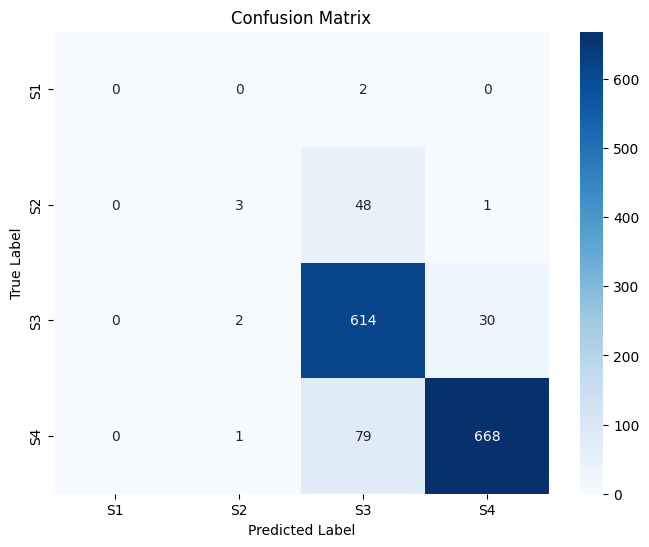

Specificity (per class): [1.0, 0.9978510028653295, 0.8391521197007481, 0.9557142857142857]
Recall (per class): [0.0, 0.057692307692307696, 0.9504643962848297, 0.893048128342246]
Precision (per class): [0, 0.5, 0.8263795423956931, 0.9556509298998569]
F1-score (per class): [0, 0.10344827586206896, 0.8840892728581713, 0.9232895646164477]
AUC-ROC for class S1: 0.5000
AUC-ROC for class S2: 0.5278
AUC-ROC for class S3: 0.8948
AUC-ROC for class S4: 0.9244


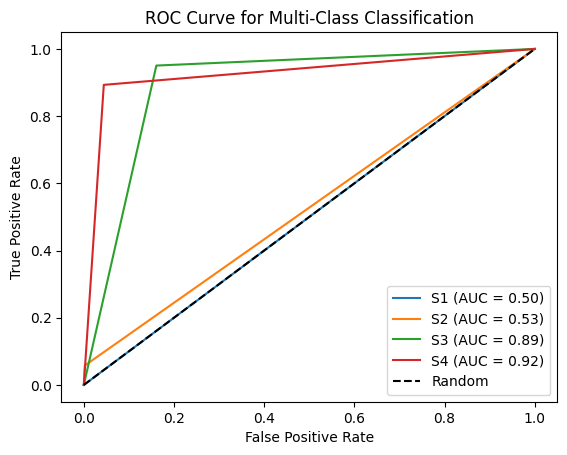

In [124]:
class_names = ['S1', 'S2', 'S3', 'S4']  # Replace with your actual class names
y_pred = run_rf(X_train,, y_train, X_test, y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

# XGBoost

In [200]:
dataset = data

X = dataset.drop(['severity'],axis=1)

Y = dataset['severity']

cat_cols = [
'component'
,'status'
,'version'
]

for col in cat_cols:
    print(col)
    X[col] = X[col].astype('category')

# split data into train and test sets
seed = 7
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

component
status
version


In [85]:
import xgboost as xgb
from xgboost import DMatrix, XGBClassifier

def run_xgboost(X_train, y_train, X_test, y_test):
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test)

    dtrain = xgb.DMatrix(X_train, y_train, enable_categorical=True)
    dtest = xgb.DMatrix(X_test, y_test, enable_categorical=True)

    params = {
        'booster': 'gbtree',
        'objective': 'multi:softmax',
        'num_class': 4,
        'max_depth': 3,
        'subsample': 1.0,
        'colsample_bylevel': 0.6,
        'colsample_bytree': 0.8,
        'min_child_weight': 0.5,
        'reg_alpha': 1,
        'reg_lambda': 5,
        'gamma': 0.1,
        'learning_rate': 0.2,
        'max_delta_step': 5,
        'tree_method': 'auto'
    }

    model_xgb = xgb.train(
            params,
            dtrain,
            num_boost_round=100,
            verbose_eval=100,
            evals=[(dtrain, "train")],
        )

    y_pred = model_xgb.predict(dtest)
    y_pred = y_pred.astype(int)  # Convert y_pred to integers

    scores(y_test, y_pred)
    return le.inverse_transform(y_pred)

run_xgboost(X_train, y_train, X_test, y_test)



[0]	train-mlogloss:1.11421
[99]	train-mlogloss:0.28458
Accuracy: 0.8901933701657458
Recall: 0.8901933701657458
Precision: 0.8906456176296264
F1 Score: 0.8778248132297168
Cohen's Kappa: 0.7899005679744193
MCC: 0.7990315275739875


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


array(['S4', 'S4', 'S4', ..., 'S3', 'S3', 'S3'], dtype=object)

# LightGBM

In [277]:
import re

datalgbm = dummies(data,'component').copy()
datalgbm = dummies(datalgbm,'status').copy()
datalgbm, lemodel = lencoder(datalgbm,'severity')
datalgbm, lemodel = lencoder(datalgbm,'version')
datalgbm['assigned_to_detail_id'] = datalgbm['assigned_to_detail.id']
dataset = datalgbm

X = dataset.drop(['severity','status','component'],axis=1)

Y = dataset['severity']

def find_problematic_columns(df):
  """Finds columns with special characters in their names."""
  problematic_columns = []
  for column in df.columns:
    if re.search('[^A-Za-z0-9_]+', column):
      problematic_columns.append(column)
  return problematic_columns

# Find problematic columns in X_train and X_test
problematic_columns = find_problematic_columns(X_train)
X = X.drop(problematic_columns, axis=1)

In [278]:


# split data into train and test sets
seed = 7
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Accuracy: 0.8888
Confusion Matrix:
    S1  S2   S3   S4
S1   0   0    2    0
S2   0   0   52    0
S3   0   0  629   17
S4   0   0   90  658


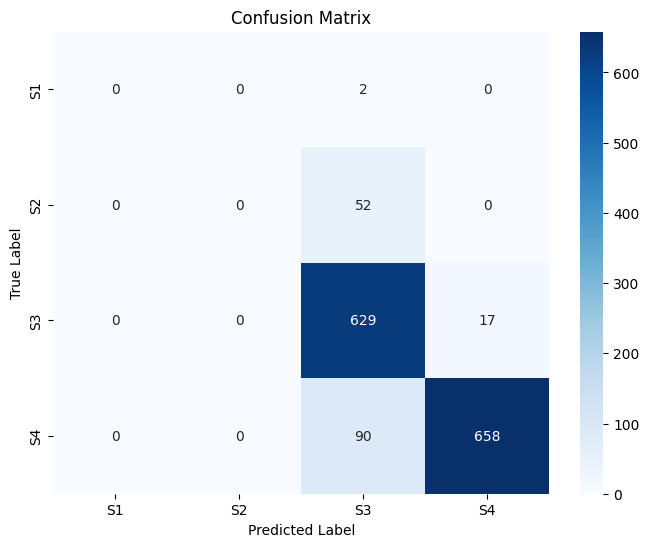

Specificity (per class): [1.0, 1.0, 0.8204488778054863, 0.9757142857142858]
Recall (per class): [0.0, 0.0, 0.9736842105263158, 0.8796791443850267]
Precision (per class): [0, 0, 0.8137128072445019, 0.9748148148148148]
F1-score (per class): [0, 0, 0.8865398167723749, 0.9248067463106113]
AUC-ROC for class S1: 0.5000
AUC-ROC for class S2: 0.5000
AUC-ROC for class S3: 0.8971
AUC-ROC for class S4: 0.9277


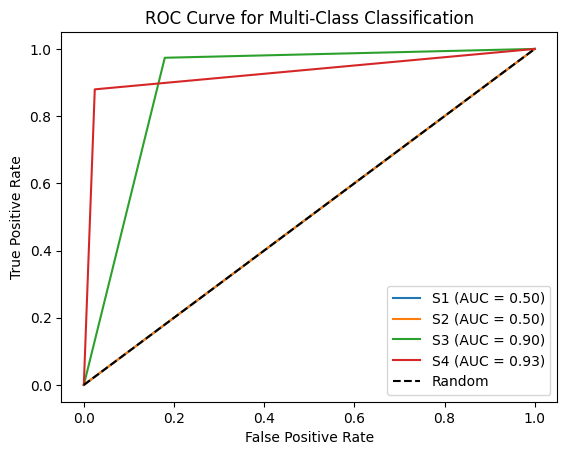

In [279]:
import lightgbm as lgb
from lightgbm import early_stopping
import numpy as np


def run_lightgbm(X_train, y_train, X_test, y_test):

    params = {
        'objective': 'multiclass',  # Example for binary classification
        'boosting_type': 'gbdt',
        'metric': ['multi_logloss', 'multi_error'], # Multiple metrics for optimization
        'num_class': 4,
        'num_leaves': 31,
        'learning_rate': 0.1,
        'n_estimators': 1000,
        'num_leaves': 31,
        'max_depth': 5,
        'min_data_in_leaf': 20,
        'reg_alpha': 0.1,
        'reg_lambda': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'early_stopping_rounds': 10,
        'verbose': -1  # Suppress output
    }

    # Create LightGBM datasets
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

    # Train the model
    model = lgb.train(params, train_data, valid_sets=[test_data],
                      # verbose_eval=False
                      )

    # Make predictions
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    # Use argmax to get the class with the highest probability
    y_pred = np.argmax(y_pred, axis=1)

    # Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    # report = classification_report(y_test, y_pred)

    # print(f"Accuracy: {accuracy:.4f}")
    # print(report)

    return y_pred

class_names = ['S1', 'S2', 'S3', 'S4']  # Replace with your actual class names
y_pred = run_lightgbm(X_train, y_train, X_test, y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

# CATBoost

In [281]:
import re

datacat = dummies(data,'component').copy()
datacat = dummies(datacat,'status').copy()
datacat, lemodel = lencoder(datacat,'severity')
datacat, lemodel = lencoder(datacat,'version')
datacat['assigned_to_detail_id'] = datacat['assigned_to_detail.id']
dataset = datacat

X = dataset.drop(['severity','status','component'],axis=1)

Y = dataset['severity']

def find_problematic_columns(df):
  """Finds columns with special characters in their names."""
  problematic_columns = []
  for column in df.columns:
    if re.search('[^A-Za-z0-9_]+', column):
      problematic_columns.append(column)
  return problematic_columns

# Find problematic columns in X_train and X_test
problematic_columns = find_problematic_columns(X_train)
X = X.drop(problematic_columns, axis=1)

# split data into train and test sets
seed = 7
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

Accuracy: 0.8826
Confusion Matrix:
    S1  S2   S3   S4
S1   0   0    2    0
S2   0   0   52    0
S3   0   0  628   18
S4   0   0   98  650


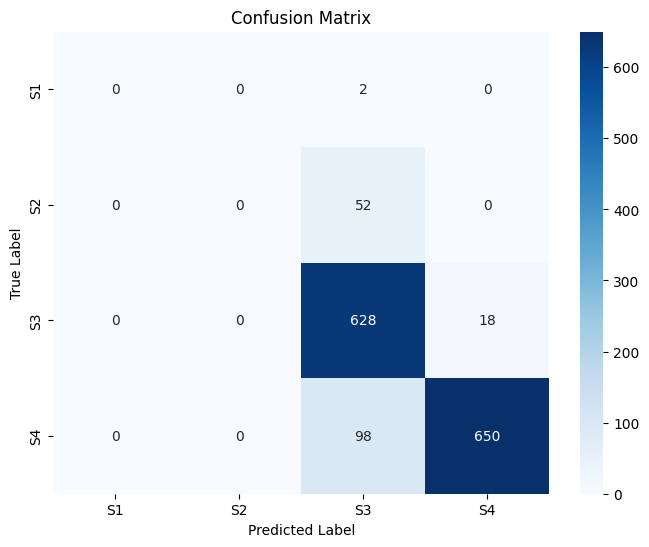

Specificity (per class): [1.0, 1.0, 0.8104738154613467, 0.9742857142857143]
Recall (per class): [0.0, 0.0, 0.9721362229102167, 0.8689839572192514]
Precision (per class): [0, 0, 0.8051282051282052, 0.9730538922155688]
F1-score (per class): [0, 0, 0.8807854137447406, 0.9180790960451977]
AUC-ROC for class S1: 0.5000
AUC-ROC for class S2: 0.5000
AUC-ROC for class S3: 0.8913
AUC-ROC for class S4: 0.9216


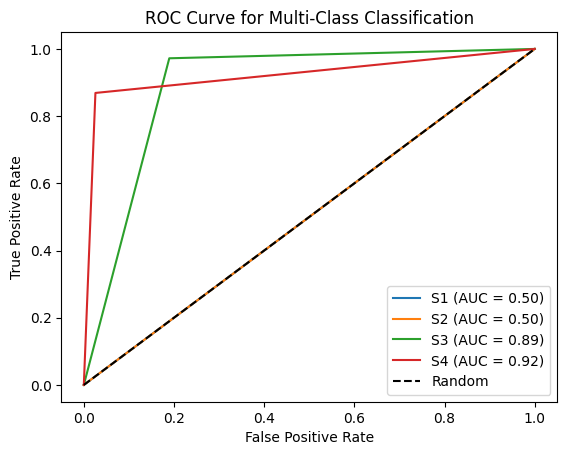

In [282]:
import catboost as cb
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


def run_catboost(X_train, y_train, X_test, y_test):

    # Before creating the CatBoost Pool, ensure y_train is a Series or 1D array
    if isinstance(y_train, pd.DataFrame):
        if len(y_train.columns) > 1:
            # If it's a DataFrame with multiple columns, select the first one
            y_train = y_train.iloc[:, 0]
        else:
            # If it's a DataFrame with one column, convert it to a Series
            y_train = y_train.squeeze()
    elif not isinstance(y_train, (pd.Series, np.ndarray)):
        # Convert to a Series if it's not already
        y_train = pd.Series(y_train)

    # Create CatBoost Pool after ensuring y_train is in the correct format
    train_data = cb.Pool(data=X_train, label=y_train)
    test_data = cb.Pool(data=X_test, label=y_test)

    # Define model parameters
    params = {
        'iterations': 100,  # Number of boosting rounds
        'learning_rate': 0.1,  # Step size at each iteration
        'depth': 6,  # Depth of trees
        'loss_function': 'MultiClass',  # Loss function for multi-class classification
        'eval_metric': 'Accuracy',  # Evaluation metric
        'verbose': False  # Suppress training output
    }

    # Initialize and train the model
    model = cb.CatBoostClassifier(**params)
    model.fit(train_data, eval_set=test_data)

    # Make predictions
    y_pred = model.predict(test_data)
    # Convert predictions to 1D array if necessary
    y_pred = y_pred.flatten() if y_pred.ndim > 1 else y_pred

    return y_pred

class_names = ['S1', 'S2', 'S3', 'S4']  # Replace with your actual class names
y_pred = run_catboost(X_train, y_train, X_test, y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)


# Gradient boosting

In [290]:
import re

datagb = dummies(data,'component').copy()
datagb = dummies(datagb,'status').copy()
datagb, lemodel = lencoder(datagb,'severity')
datagb, lemodel = lencoder(datagb,'version')
datagb['assigned_to_detail_id'] = datagb['assigned_to_detail.id']
dataset = datagb

X = dataset.drop(['severity','status','component'],axis=1)

Y = dataset['severity']

def find_problematic_columns(df):
  """Finds columns with special characters in their names."""
  problematic_columns = []
  for column in df.columns:
    if re.search('[^A-Za-z0-9_]+', column):
      problematic_columns.append(column)
  return problematic_columns

# Find problematic columns in X_train and X_test
problematic_columns = find_problematic_columns(X_train)
X = X.drop(problematic_columns, axis=1)

# split data into train and test sets
seed = 7
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

Accuracy: 0.8798
Confusion Matrix:
    S1  S2   S3   S4
S1   0   0    2    0
S2   2   4   46    0
S3   1   8  614   23
S4   0   2   90  656


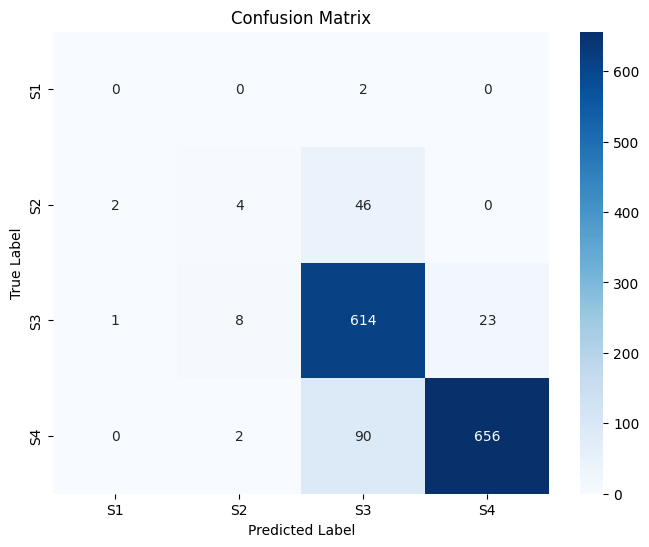

Specificity (per class): [0.9979253112033195, 0.9928366762177651, 0.827930174563591, 0.9671428571428572]
Recall (per class): [0.0, 0.07692307692307693, 0.9504643962848297, 0.8770053475935828]
Precision (per class): [0.0, 0.2857142857142857, 0.8164893617021277, 0.9661266568483063]
F1-score (per class): [0, 0.12121212121212123, 0.8783977110157368, 0.9194113524877365]
AUC-ROC for class S1: 0.4990
AUC-ROC for class S2: 0.5349
AUC-ROC for class S3: 0.8892
AUC-ROC for class S4: 0.9221


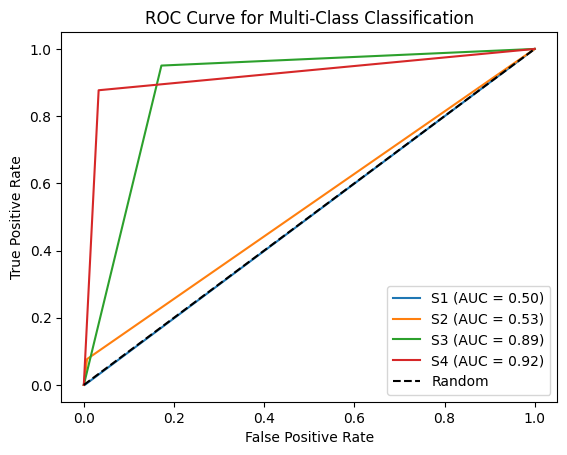

In [296]:
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd
import numpy as np

def run_gradient_boosting(X_train, y_train, X_test, y_test):

    # Before training, ensure y_train is a Series or 1D array
    if isinstance(y_train, pd.DataFrame):
        if len(y_train.columns) > 1:
            # If it's a DataFrame with multiple columns, select the first one
            y_train = y_train.iloc[:, 0]
        else:
            # If it's a DataFrame with one column, convert it to a Series
            y_train = y_train.squeeze()
    elif not isinstance(y_train, (pd.Series, np.ndarray)):
        # Convert to a Series if it's not already
        y_train = pd.Series(y_train)

    # Initialize and train the model
    model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    return y_pred

class_names = ['S1', 'S2', 'S3', 'S4']  # Replace with your actual class names
y_pred = run_gradient_boosting(X_train, y_train, X_test, y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

# Extra Trees

In [300]:
dataet = dummies(data,'component').copy()
dataet, lemodel = lencoder(dataet,'severity')
dataet, lemodel = lencoder(dataet,'version')
dataet['assigned_to_detail.id'] = dataet['assigned_to_detail.id']

dataet = dataet.drop(['component'
    ,'status'#,'Pdescription'
    ],axis=1)

In [301]:
dataset = dataet

X = dataset.drop(['severity'
],axis=1)

Y = dataset['severity']


# split data into train and test sets
seed = 7
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

Accuracy: 0.8854
Confusion Matrix:
    S1  S2   S3   S4
S1   0   0    2    0
S2   0   4   47    1
S3   0   3  601   42
S4   0   5   66  677


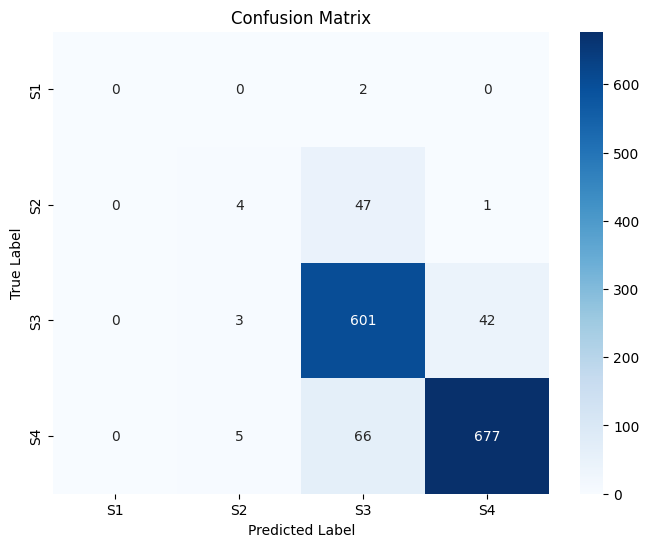

Specificity (per class): [1.0, 0.994269340974212, 0.8566084788029925, 0.9385714285714286]
Recall (per class): [0.0, 0.07692307692307693, 0.9303405572755418, 0.9050802139037433]
Precision (per class): [0, 0.3333333333333333, 0.8393854748603352, 0.9402777777777778]
F1-score (per class): [0, 0.125, 0.8825256975036712, 0.9223433242506812]
AUC-ROC for class S1: 0.5000
AUC-ROC for class S2: 0.5356
AUC-ROC for class S3: 0.8935
AUC-ROC for class S4: 0.9218


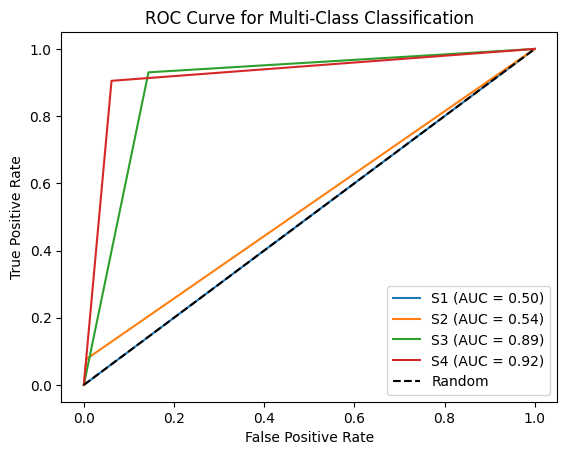

In [305]:
from sklearn.ensemble import ExtraTreesClassifier
import pandas as pd
import numpy as np

def run_et(X_train, y_train, X_test, y_test):
    """
    Trains an Extra Trees Classifier model and makes predictions.

    Args:
        X_train: Training data features.
        y_train: Training data target variable.
        X_test: Testing data features.
        y_test: Testing data target variable.

    Returns:
        y_pred: Predicted target variable for the testing data.
    """

    # Before training, ensure y_train is a Series or 1D array
    if isinstance(y_train, pd.DataFrame):
        if len(y_train.columns) > 1:
            # If it's a DataFrame with multiple columns, select the first one
            y_train = y_train.iloc[:, 0]
        else:
            # If it's a DataFrame with one column, convert it to a Series
            y_train = y_train.squeeze()
    elif not isinstance(y_train, (pd.Series, np.ndarray)):
        # Convert to a Series if it's not already
        y_train = pd.Series(y_train)

    # Initialize and train the model
    model = ExtraTreesClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    return y_pred

class_names = ['S1', 'S2', 'S3', 'S4']  # Replace with your actual class names
y_pred = run_et(X_train, y_train, X_test, y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

# Decision Tree

In [311]:
datadt = dummies(data,'component').copy()
datadt, lemodel = lencoder(datadt,'severity')
datadt, lemodel = lencoder(datadt,'version')
datadt['assigned_to_detail.id'] = datadt['assigned_to_detail.id']

datadt = datadt.drop(['component'
    ,'status'#,'Pdescription'
    ],axis=1)

dataset = datadt

X = dataset.drop(['severity'
],axis=1)

Y = dataset['severity']


# split data into train and test sets
seed = 7
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

Accuracy: 0.8854
Confusion Matrix:
    S1  S2   S3   S4
S1   0   0    2    0
S2   0   4   47    1
S3   0   3  601   42
S4   0   5   66  677


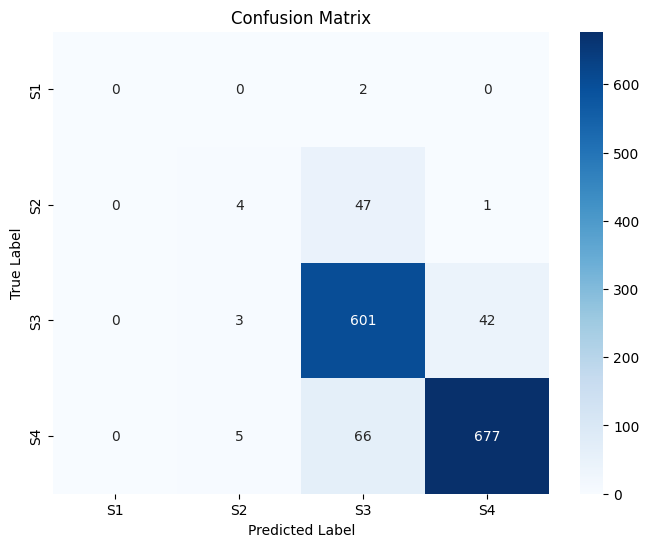

Specificity (per class): [1.0, 0.994269340974212, 0.8566084788029925, 0.9385714285714286]
Recall (per class): [0.0, 0.07692307692307693, 0.9303405572755418, 0.9050802139037433]
Precision (per class): [0, 0.3333333333333333, 0.8393854748603352, 0.9402777777777778]
F1-score (per class): [0, 0.125, 0.8825256975036712, 0.9223433242506812]
AUC-ROC for class S1: 0.5000
AUC-ROC for class S2: 0.5356
AUC-ROC for class S3: 0.8935
AUC-ROC for class S4: 0.9218


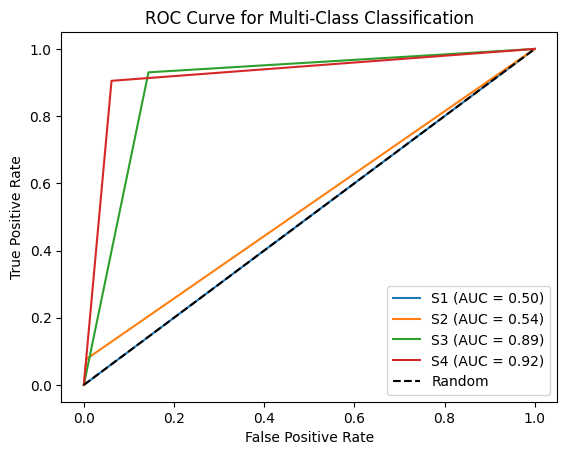

In [312]:
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np

def run_dt(X_train, y_train, X_test, y_test):
    """
    Trains a Decision Tree Classifier model and makes predictions.

    Args:
        X_train: Training data features.
        y_train: Training data target variable.
        X_test: Testing data features.
        y_test: Testing data target variable.

    Returns:
        y_pred: Predicted target variable for the testing data.
    """

    # Before training, ensure y_train is a Series or 1D array
    if isinstance(y_train, pd.DataFrame):
        if len(y_train.columns) > 1:
            # If it's a DataFrame with multiple columns, select the first one
            y_train = y_train.iloc[:, 0]
        else:
            # If it's a DataFrame with one column, convert it to a Series
            y_train = y_train.squeeze()
    elif not isinstance(y_train, (pd.Series, np.ndarray)):
        # Convert to a Series if it's not already
        y_train = pd.Series(y_train)

    # Initialize and train the model
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    return y_pred

class_names = ['S1', 'S2', 'S3', 'S4']  # Replace with your actual class names
y_pred = run_et(X_train, y_train, X_test, y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

# MLP

In [16]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [87]:
# !pip install tensorflow pandas scikit-learn

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Preprocessing: One-hot encoding for categorical features
def preprocess_data(X_train, X_test, y_train):
    """Preprocesses the data by one-hot encoding categorical features and scaling numerical features.

    Args:
        X_train: The training data features.
        X_test: The testing data features.
        y_train: The training data labels.

    Returns:
        Preprocessed X_train, X_test, y_train, and a LabelEncoder for y.
    """
    # Handle categorical features in X_train and X_test
    categorical_cols_train = X_train.select_dtypes(include=['object']).columns
    categorical_cols_test = X_test.select_dtypes(include=['object']).columns

    # Use the same columns for one-hot encoding in both train and test
    categorical_cols = list(set(categorical_cols_train) | set(categorical_cols_test))

    X_train = pd.get_dummies(X_train, columns=categorical_cols, dummy_na=False)
    X_test = pd.get_dummies(X_test, columns=categorical_cols, dummy_na=False)

    # Align columns to ensure they are the same in both train and test
    X_train, X_test = X_train.align(X_test, join='outer', axis=1, fill_value=0)

    # Handle numerical features: Scaling
    numerical_cols = X_train.select_dtypes(include=['number']).columns
    scaler = StandardScaler()
    X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
    X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

    # Convert y_train to numerical using Label Encoding
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)

    return X_train, X_test, y_train_encoded, label_encoder


# Building and training the MLP model
def build_and_train_mlp(X_train, y_train, num_classes, epochs=10, verbose=1): # verbose parameter added
    input_dim = X_train.shape[1]
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(input_dim, activation='tanh', input_shape=(input_dim,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=verbose, validation_split=0.3)
    return model, history

In [88]:
X = data.drop('severity', axis=1)  # Replace 'target_variable' with your target column name
y = data['severity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)


def run_mlp(X_train, y_train, X_test, y_test):
    # 1. Preprocess the data:
    X_train_processed, X_test_processed, y_train_encoded, label_encoder = preprocess_data(X_train, X_test, y_train)


    # 3. Build and train the model (using strategy for GPU distribution):
    num_classes = len(label_encoder.classes_)
    desired_epochs = 15  # Set the desired number of epochs here


    # Configure TensorFlow to use GPU if available
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        strategy = tf.distribute.MirroredStrategy()
        with strategy.scope():
            model, history = build_and_train_mlp(X_train_processed, y_train_encoded, num_classes, epochs=desired_epochs, verbose=2)
    else:
        model, history = build_and_train_mlp(X_train_processed, y_train_encoded, num_classes, epochs=desired_epochs, verbose=2)

    # 4. Evaluate the model:
    y_test_encoded = label_encoder.transform(y_test)  # Encode y_test using the same label encoder
    loss, accuracy = model.evaluate(X_test_processed, y_test_encoded)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

    # 5. Make predictions (optional):
    y_pred = model.predict(X_test_processed)
    predicted_labels = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))

    return predicted_labels




/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
90/90 - 4s - 42ms/step - accuracy: 0.6623 - loss: 1.4401 - val_accuracy: 0.7333 - val_loss: 0.9641
Epoch 2/15
90/90 - 1s - 15ms/step - accuracy: 0.9184 - loss: 0.2353 - val_accuracy: 0.7244 - val_loss: 1.1708
Epoch 3/15
90/90 - 2s - 18ms/step - accuracy: 0.9672 - loss: 0.0992 - val_accuracy: 0.7333 - val_loss: 1.2739
Epoch 4/15
90/90 - 1s - 14ms/step - accuracy: 0.9756 - loss: 0.0692 - val_accuracy: 0.7390 - val_loss: 1.3136
Epoch 5/15
90/90 - 1s - 13ms/step - accuracy: 0.9794 - loss: 0.0534 - val_accuracy: 0.7260 - val_loss: 1.3766
Epoch 6/15
90/90 - 1s - 13ms/step - accuracy: 0.9805 - loss: 0.0553 - val_accuracy: 0.7114 - val_loss: 1.7258
Epoch 7/15
90/90 - 1s - 13ms/step - accuracy: 0.9801 - loss: 0.0576 - val_accuracy: 0.7309 - val_loss: 1.5323
Epoch 8/15
90/90 - 1s - 13ms/step - accuracy: 0.9843 - loss: 0.0424 - val_accuracy: 0.7366 - val_loss: 1.4839
Epoch 9/15
90/90 - 1s - 13ms/step - accuracy: 0.9861 - loss: 0.0445 - val_accuracy: 0.7195 - val_loss: 1.7358
Epoch 10/1

In [103]:
# Calculate and plot metrics:

def calculate_metrics_mlp(model, history, X_test_processed, y_test, label_encoder):
    """Calculates and plots training/validation accuracy and loss, confusion matrix, AUC-ROC curve.

    Args:
        model: The trained model.
        history: The training history object returned by model.fit.
        X_test_processed: The processed test data.
        y_test: The true labels for the test data.
        label_encoder: The LabelEncoder used for encoding the labels.
    """

    # Plot training & validation accuracy
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

   # Get predicted probabilities and convert to predicted labels
    y_pred_prob = model.predict(X_test_processed)  # Get predicted probabilities
    y_pred = np.argmax(y_pred_prob, axis=1)  # Convert to predicted labels

    # Convert y_test to numerical labels to match y_pred
    y_test_encoded = label_encoder.transform(y_test)

    # Confusion Matrix with Class Names
    cm = confusion_matrix(y_test_encoded, y_pred)  # Use y_test_encoded and y_pred

    if class_names is not None:
        cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
        print(f"Confusion Matrix:\n{cm_df}")
    else:
        print(f"Confusion Matrix:\n{cm}")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    #Calculate Specificity, Recall, Precision, F1-Score for Multi-class
    num_classes = cm.shape[0]
    specificity = []
    recall = []
    precision = []
    f1 = []

    for i in range(num_classes):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        tn = cm.sum() - (tp + fp + fn)

        specificity.append(tn / (tn + fp) if (tn + fp) != 0 else 0)
        recall.append(tp / (tp + fn) if (tp + fn) != 0 else 0)
        precision.append(tp / (tp + fp) if (tp + fp) != 0 else 0)
        f1.append(2 * (precision[i] * recall[i]) / (precision[i] + recall[i]) if (precision[i] + recall[i]) != 0 else 0)

    print(f"Specificity (per class): {specificity}")
    print(f"Recall (per class): {recall}")
    print(f"Precision (per class): {precision}")
    print(f"F1-score (per class): {f1}")






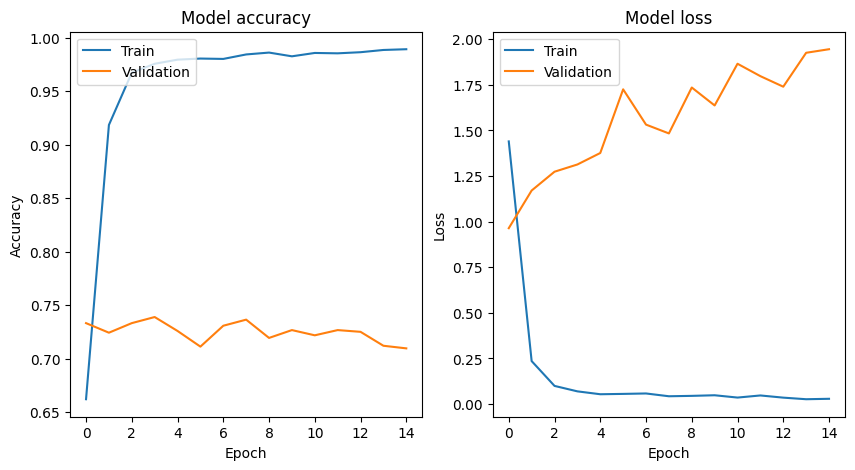

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Confusion Matrix:
    S1   S2   S3   S4
S1  21    8   28    5
S2   3  201   84    6
S3  17  150  415   89
S4   7   35   62  626


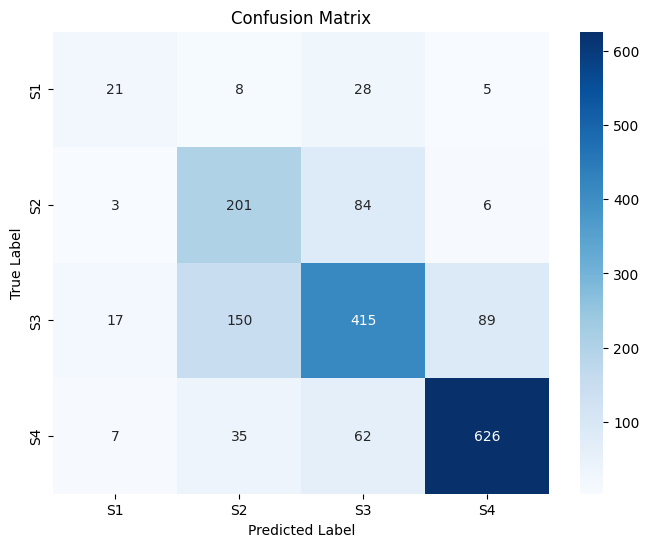

Specificity (per class): [0.984070796460177, 0.8680792891319207, 0.8397790055248618, 0.9026290165530672]
Recall (per class): [0.3387096774193548, 0.6836734693877551, 0.6184798807749627, 0.8575342465753425]
Precision (per class): [0.4375, 0.5101522842639594, 0.7045840407470289, 0.8622589531680441]
F1-score (per class): [0.3818181818181818, 0.5843023255813953, 0.6587301587301587, 0.8598901098901099]


In [104]:
calculate_metrics_mlp(model, history, X_test_processed, y_test, label_encoder)

# PyCaret top 7

In [ ]:
from pycaret.classification import *

# dataset = data

# data = dataset.drop(['priority'
# ,'resolution'
# ,'product'
# ,'creation_time'
# ,'classification'
# ,'type'
# ,'last_change_time'
# ,'component'
# ,'status'
# ],axis=1)

clf1 = setup(data, target='severity')

model = [create_model(i) for i in [
    'rf',
    'gbc',
    'et',
    'xgboost',
    'catboost',
    'lightgbm',
    'dt']]

for i in (range(7)):
    print(i)
    model[i].get_params()


,Description,Value
0,Session id,8869
1,Target,severity
2,Target type,Multiclass
3,Target mapping,"S1: 0, S2: 1, S3: 2, S4: 3"
4,Original data shape,"(4826, 3199)"
5,Transformed data shape,"(4826, 3218)"
6,Transformed train set shape,"(3378, 3218)"
7,Transformed test set shape,"(1448, 3218)"
8,Numeric features,3195
9,Categorical features,3


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8787,0.0000,0.8787,0.8612,0.8664,0.7665,0.7735
1,0.8728,0.0000,0.8728,0.8942,0.8632,0.7561,0.7707
2,0.8669,0.0000,0.8669,0.8800,0.8573,0.7438,0.7512
3,0.8698,0.0000,0.8698,0.8527,0.8565,0.7491,0.7583
4,0.8787,0.9280,0.8787,0.8905,0.8675,0.7675,0.7767
5,0.8846,0.9342,0.8846,0.8945,0.8735,0.7786,0.7861
6,0.8994,0.9531,0.8994,0.8772,0.8843,0.8065,0.8149
7,0.8935,0.9455,0.8935,0.8691,0.8782,0.7949,0.8015
8,0.9021,0.0000,0.9021,0.9118,0.8918,0.8113,0.8171


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8728,0.0000,0.8728,0.8717,0.8672,0.7578,0.7644
1,0.8462,0.0000,0.8462,0.8449,0.8372,0.7066,0.7206
2,0.8639,0.0000,0.8639,0.8520,0.8533,0.7391,0.7478
3,0.8698,0.0000,0.8698,0.8867,0.8603,0.7500,0.7606
4,0.8787,0.0000,0.8787,0.8830,0.8748,0.7703,0.7782
5,0.8876,0.0000,0.8876,0.8996,0.8765,0.7845,0.7939
6,0.8935,0.0000,0.8935,0.8806,0.8837,0.7971,0.8031
7,0.8876,0.0000,0.8876,0.8854,0.8797,0.7850,0.7895
8,0.9021,0.0000,0.9021,0.8974,0.8928,0.8117,0.8165


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8876,0.0000,0.8876,0.8853,0.8784,0.7841,0.7907
1,0.8669,0.0000,0.8669,0.8735,0.8584,0.7453,0.7582
2,0.8698,0.0000,0.8698,0.8842,0.8614,0.7501,0.7565
3,0.8669,0.0000,0.8669,0.8654,0.8582,0.7444,0.7506
4,0.8698,0.9141,0.8698,0.8759,0.8636,0.7511,0.7559
5,0.8728,0.9314,0.8728,0.8671,0.8627,0.7562,0.7614
6,0.8935,0.9457,0.8935,0.8687,0.8783,0.7948,0.8009
7,0.8905,0.9464,0.8905,0.8939,0.8788,0.7891,0.7919
8,0.8991,0.0000,0.8991,0.9083,0.8889,0.8055,0.8108


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8817,0.0000,0.8817,0.8787,0.8737,0.7735,0.7813
1,0.8373,0.0000,0.8373,0.8440,0.8361,0.6934,0.7001
2,0.8669,0.0000,0.8669,0.8570,0.8578,0.7452,0.7527
3,0.8669,0.0000,0.8669,0.8530,0.8560,0.7445,0.7519
4,0.8817,0.9403,0.8817,0.8843,0.8773,0.7759,0.7838
5,0.8728,0.9328,0.8728,0.8661,0.8638,0.7570,0.7633
6,0.9053,0.9518,0.9053,0.8998,0.8946,0.8187,0.8254
7,0.8787,0.9434,0.8787,0.8608,0.8677,0.7679,0.7719
8,0.8991,0.0000,0.8991,0.9052,0.8886,0.8051,0.8081


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8787,0.0000,0.8787,0.8816,0.8700,0.7676,0.7778
1,0.8402,0.0000,0.8402,0.8389,0.8325,0.6959,0.7074
2,0.8698,0.0000,0.8698,0.8560,0.8566,0.7495,0.7615
3,0.8669,0.0000,0.8669,0.8522,0.8537,0.7437,0.7549
4,0.8757,0.9335,0.8757,0.8900,0.8646,0.7620,0.7733
5,0.8757,0.9284,0.8757,0.8572,0.8611,0.7613,0.7718
6,0.8964,0.9477,0.8964,0.8757,0.8826,0.8012,0.8084
7,0.8787,0.9401,0.8787,0.8633,0.8679,0.7682,0.7740
8,0.9110,0.0000,0.9110,0.9211,0.9006,0.8285,0.8350


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8669,0.0000,0.8669,0.8504,0.8559,0.7442,0.7495
1,0.8402,0.0000,0.8402,0.8432,0.8356,0.6960,0.7038
2,0.8728,0.0000,0.8728,0.8663,0.8649,0.7560,0.7605
3,0.8728,0.0000,0.8728,0.8669,0.8659,0.7568,0.7617
4,0.8728,0.9461,0.8728,0.8680,0.8683,0.7590,0.7619
5,0.8817,0.9261,0.8817,0.8758,0.8762,0.7753,0.7786
6,0.8905,0.9555,0.8905,0.8642,0.8764,0.7891,0.7917
7,0.8787,0.9455,0.8787,0.8654,0.8699,0.7680,0.7700
8,0.9021,0.0000,0.9021,0.8752,0.8877,0.8102,0.8131


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8284,0.0000,0.8284,0.8263,0.8273,0.6749,0.6749
1,0.8462,0.0000,0.8462,0.8530,0.8473,0.7109,0.7143
2,0.8343,0.0000,0.8343,0.8255,0.8286,0.6830,0.6843
3,0.8580,0.0000,0.8580,0.8507,0.8527,0.7279,0.7286
4,0.8432,0.8639,0.8432,0.8481,0.8450,0.7075,0.7083
5,0.8550,0.8722,0.8550,0.8532,0.8526,0.7266,0.7289
6,0.8491,0.8608,0.8491,0.8356,0.8417,0.7115,0.7123
7,0.8817,0.8924,0.8817,0.8745,0.8773,0.7749,0.7754
8,0.8694,0.0000,0.8694,0.8624,0.8655,0.7506,0.7508


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

0
1
2
3
4
5
6


In [ ]:
# import pickle as pk
# i=0
# for m in [
#           'rf',
#           'gbc',
#           'et',
#           'xgboost',
#           'catboost',
#           'lightgbm',
#           'dt']:
#   print(model[i].get_params())
#   name=m+'.pkl'
#   with open(name, "wb") as file: # file is a variable for storing the newly created file, it can be anything.
#     pk.dump(model, file) # Dump function is used to write the object into the created file in byte format.
#   i+=1

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 8869, 'verbose': 0, 'warm_start': False}
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 8869, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': No

# PyCaret Optimise

In [ ]:
tuned_model = tune_model(model[1])

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,03:23:34
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Gradient Boosting Classifier


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [ ]:
tuned_model.get_params()

{'objective': 'multi:softprob',
 'base_score': None,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 1,
 'device': 'cpu',
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.3,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 5,
 'max_leaves': None,
 'min_child_weight': 2,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 40,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': 8853,
 'reg_alpha': 1e-06,
 'reg_lambda': 3,
 'sampling_method': None,
 'scale_pos_weight': 3.5,
 'subsample': 1,
 'tree_method': 'auto',
 'validate_parameters': None,
 'verbosity': 0}

In [ ]:
# evaluate_model(tuned_model)

# Optimising

In [313]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
# Assuming X_train, X_test, y_train, y_test are already defined

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'class_weight':[None,'balanced'],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt']
}

# Create the Random Forest model
rf_model = RandomForestClassifier(random_state=seed)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                          scoring='accuracy', cv=5, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

# Evaluate the model with the best parameters
best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test)

# Calculate and print the metrics
# calculate_metrics(y_test, y_pred)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# dataset = mergeddata

# X = dataset.drop(['severity','priority'
# ,'resolution'
# ,'product'
# ,'creation_time'
# ,'classification'
# ,'type'
# ,'last_change_time'
# ,'component'
# ,'status'
# ,'assigned_to'
# ,'assigned_to_detail.nick'
# ,'assigned_to_detail.name'
# ,'assigned_to_detail.email'
#                 ],axis=1)

# Y = dataset['severity']

# # split data into train and test sets
# seed = 7
# test_size = 0.3
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)


In [ ]:
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.metrics import accuracy_score
# import pickle

# # model[3].save_model('xgb_model.model')

# # modelxgb = cuml.xgboost.XGBClassifier()

# # modelxgb.load_model('xgb_model.model')

# # with open('xgboost.pkl', 'rb') as f:
# #   modelxgb = pickle.load(f)

# modelxgb = model[3]

# param_grid = {
#     # 'max_depth': [3, 4, 5, 10],
#     'booster': ['dart'],
#     'max_depth': [3],
#     # 'subsample': [0.1, 0.6, 0.8, 1.0]
#     'subsample': [1.0],
#     # 'colsample_bylevel': [0.6, 0.8, 1.0]
#     'colsample_bylevel': [0.6],
#     # 'colsample_bytree': [0.6, 0.8, 1.0]
#     'colsample_bytree': [0.8],
#     # 'min_child_weight': [1, 5, 100]
#     'min_child_weight': [0.5],
#     # 'reg_alpha': [1, 5, 100],
#     # 'reg_lambda': [1, 5, 100]
#     'reg_alpha': [1],
#     'reg_lambda': [5],
#     'gamma': [0.1],
#     # 'gamma': [0, 0.1, 0.2, 0.3]
#     # 'n_estimators': [50, 100, 250, 500],
#     # 'learning_rate': [0.01, 0.2, 0.5]
#     'n_estimators': [250],
#     'learning_rate': [0.2],
#     'scale_pos_weight': [3.5],
#     # 'scale_pos_weight': [1, 5, 10],
#     'max_delta_step': [5],
#     'tree_method': ['auto']
# }

# # Set up the GridSearchCV
# grid_search = GridSearchCV(
#     estimator=modelxgb,
#     param_grid=param_grid,
#     scoring='accuracy',
#     cv=3,
#     verbose=1,
#     n_jobs=-1
# )

# # Fit the model
# grid_search.fit(X_train, y_train)

# # Get the best parameters and evaluate the model
# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)

# print(f'Best Parameters: {best_params}')
# print(f'Best Model Accuracy: {accuracy:.4f}')

# Other balancing techniques

In [314]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split

In [315]:
data['severity'].value_counts()


,count
severity,
S4,2481
S3,2182
S2,157
S1,6


In [316]:
def resample(X_train, y_train, X_test, y_test):
    # Resampling techniques
    print('ROS')
    ros = RandomOverSampler(random_state=7)
    X_ros, y_ros = ros.fit_resample(X_train, y_train)

    print('RUS')
    rus = RandomUnderSampler(random_state=7)
    X_rus, y_rus = rus.fit_resample(X_train, y_train)

    # Assuming X_train is your DataFrame with features
    # Identify columns with non-numerical data
    categorical_cols = X_train.select_dtypes(include=['object','category']).columns

    # Apply Label Encoding to categorical columns
    for col in categorical_cols:
        le = LabelEncoder()
        print(col)
        all_unique_values = pd.concat([X_train[col], X_test[col]]).unique()
        le.fit(all_unique_values)

        X_train[col] = le.transform(X_train[col])
        X_test[col] = le.transform(X_test[col])


    print('SMOTE')
    smote = SMOTE(random_state=7, k_neighbors=2)
    X_smote, y_smote = smote.fit_resample(X_train, y_train)

    # print('ADASYN')
    # adasyn = ADASYN(random_state=7, sampling_strategy='minority')
    # X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)

    # print('SMOTEENN')
    # smoteenn = SMOTEENN(random_state=7)
    # X_smoteenn, y_smoteenn = smoteenn.fit_resample(X_train, y_train)

    # return(X_ros, y_ros, X_rus, y_rus, X_smote, y_smote, X_adasyn, y_adasyn, X_smoteenn, y_smoteenn)
    return {"X_ros": X_ros, "y_ros": y_ros,
            "X_rus": X_rus, "y_rus": y_rus,
            "X_smote": X_smote, "y_smote": y_smote,
          #  "X_adasyn": X_adasyn, "y_adasyn": y_adasyn,
          #  "X_smoteenn": X_smoteenn, "y_smoteenn": y_smoteenn,
            "X_train": X_train, "X_test": X_test}



In [317]:
resampled= resample(X_train, y_train, X_test, y_test)

class_names = ['S1', 'S2', 'S3', 'S4']  # Replace with your actual class names


ROS
RUS
SMOTE


# Resampled run

In [284]:
y_pred = run_xgboost(resampled["X_ros"], resampled["y_ros"], X_test, y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

y_pred = run_xgboost(resampled["X_rus"], resampled["y_rus"], X_test, y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

y_pred = run_xgboost(resampled["X_smote"], resampled["y_smote"], resampled["X_test"], y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

# run_xgboost(resampled["X_adasyn"], resampled["y_adasyn"], resampled["X_test"], y_test)
# run_xgboost(resampled["X_smoteenn"], resampled["y_smoteenn"], resampled["X_test"], y_test)

KeyboardInterrupt: 

In [ ]:
y_pred = run_rf(resampled["X_ros"], resampled["y_ros"], X_test, y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

y_pred = run_rf(resampled["X_rus"], resampled["y_rus"], X_test, y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

y_pred = run_rf(resampled["X_smote"], resampled["y_smote"], resampled["X_test"], y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

# run_xgboost(resampled["X_adasyn"], resampled["y_adasyn"], resampled["X_test"], y_test)
# run_xgboost(resampled["X_smoteenn"], resampled["y_smoteenn"], resampled["X_test"], y_test)

In [ ]:
y_pred = run_lightgbm(resampled["X_ros"], resampled["y_ros"], X_test, y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

y_pred = run_lightgbm(resampled["X_rus"], resampled["y_rus"], X_test, y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

y_pred = run_lightgbm(resampled["X_smote"], resampled["y_smote"], resampled["X_test"], y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

# run_lightgbm(resampled["X_adasyn"], resampled["y_adasyn"], resampled["X_test"], y_test)
# run_lightgbm(resampled["X_smoteenn"], resampled["y_smoteenn"], resampled["X_test"], y_test)

Accuracy: 0.8239
Confusion Matrix:
    S1   S2   S3   S4
S1   0    2    0    0
S2   2   33   17    0
S3   3  123  504   16
S4   0   23   69  656


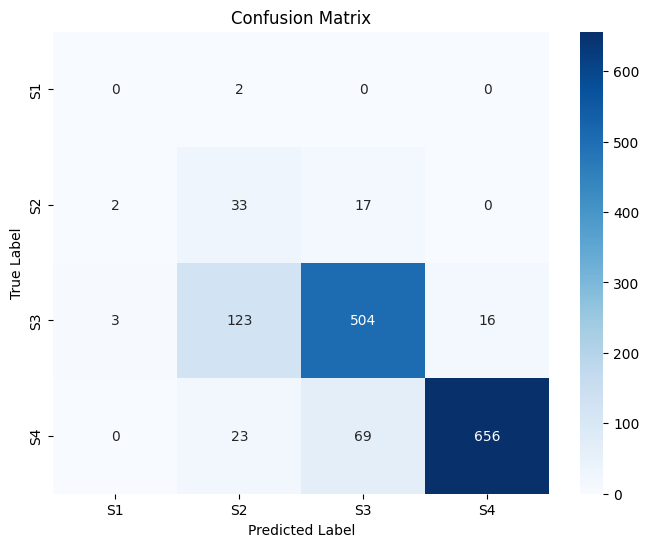

Specificity (per class): [0.9965421853388658, 0.8939828080229226, 0.8927680798004988, 0.9771428571428571]
Recall (per class): [0.0, 0.6346153846153846, 0.7801857585139319, 0.8770053475935828]
Precision (per class): [0.0, 0.18232044198895028, 0.8542372881355932, 0.9761904761904762]
F1-score (per class): [0, 0.2832618025751073, 0.8155339805825242, 0.9239436619718309]
AUC-ROC for class S1: 0.4983
AUC-ROC for class S2: 0.7643
AUC-ROC for class S3: 0.8365
AUC-ROC for class S4: 0.9271


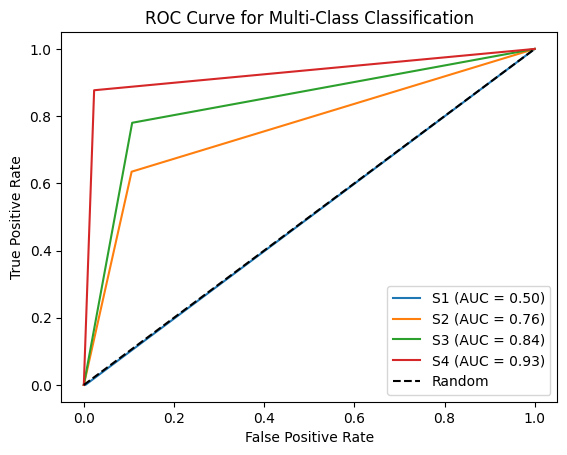

Accuracy: 0.6782
Confusion Matrix:
    S1   S2   S3   S4
S1   1    0    1    0
S2   5   20   27    0
S3  11  268  348   19
S4   2   37   96  613


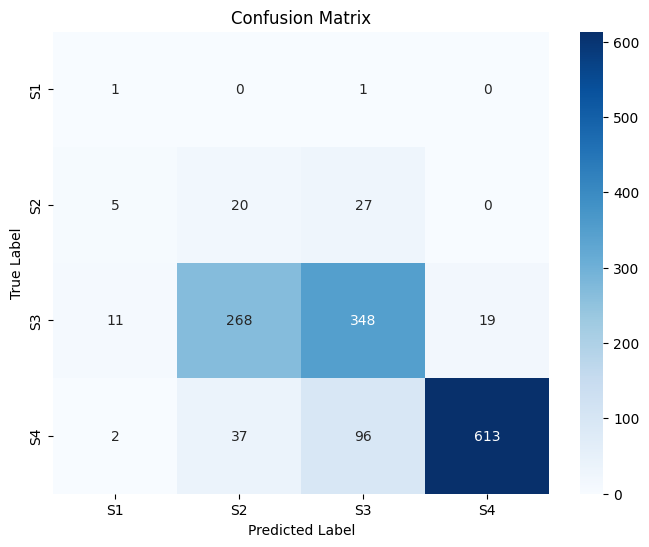

Specificity (per class): [0.9875518672199171, 0.7815186246418339, 0.8453865336658354, 0.9728571428571429]
Recall (per class): [0.5, 0.38461538461538464, 0.5386996904024768, 0.81951871657754]
Precision (per class): [0.05263157894736842, 0.06153846153846154, 0.7372881355932204, 0.9699367088607594]
F1-score (per class): [0.09523809523809525, 0.10610079575596817, 0.6225402504472272, 0.8884057971014493]
AUC-ROC for class S1: 0.7438
AUC-ROC for class S2: 0.5831
AUC-ROC for class S3: 0.6920
AUC-ROC for class S4: 0.8962


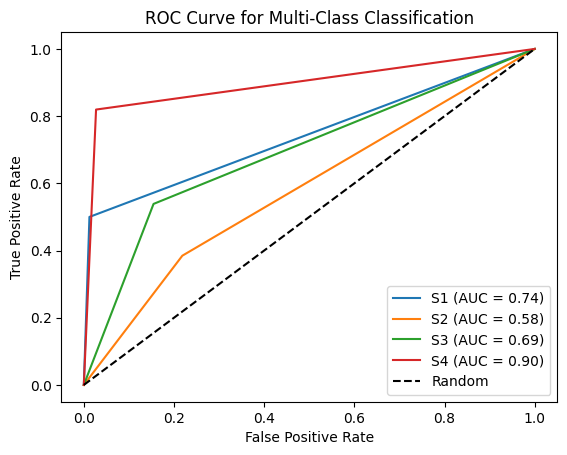

Accuracy: 0.8460
Confusion Matrix:
    S1  S2   S3   S4
S1   1   1    0    0
S2   4  18   30    0
S3   4  76  551   15
S4   1   8   84  655


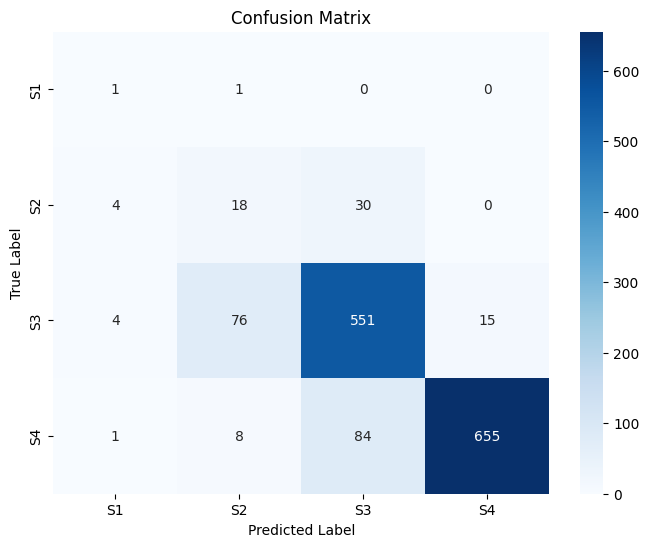

Specificity (per class): [0.9937759336099585, 0.9391117478510028, 0.85785536159601, 0.9785714285714285]
Recall (per class): [0.5, 0.34615384615384615, 0.8529411764705882, 0.8756684491978609]
Precision (per class): [0.1, 0.17475728155339806, 0.8285714285714286, 0.9776119402985075]
F1-score (per class): [0.16666666666666669, 0.23225806451612904, 0.8405797101449276, 0.923836389280677]
AUC-ROC for class S1: 0.7469
AUC-ROC for class S2: 0.6426
AUC-ROC for class S3: 0.8554
AUC-ROC for class S4: 0.9271


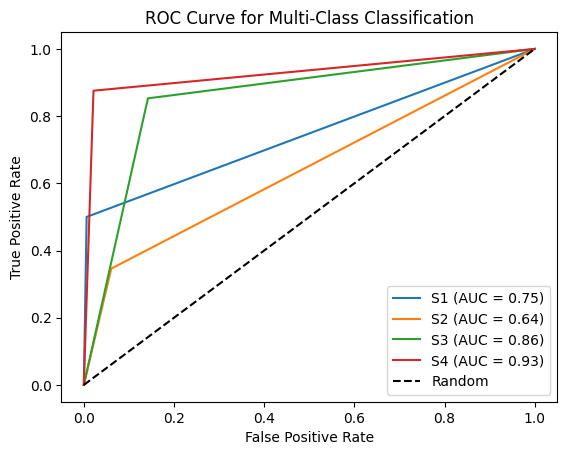

In [289]:
y_pred = run_catboost(resampled["X_ros"], resampled["y_ros"], X_test, y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

y_pred = run_catboost(resampled["X_rus"], resampled["y_rus"], X_test, y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

y_pred = run_catboost(resampled["X_smote"], resampled["y_smote"], resampled["X_test"], y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

# run_catboost(resampled["X_adasyn"], resampled["y_adasyn"], resampled["X_test"], y_test)
# run_catboost(resampled["X_smoteenn"], resampled["y_smoteenn"], resampled["X_test"], y_test)

Accuracy: 0.8232
Confusion Matrix:
    S1   S2   S3   S4
S1   0    1    1    0
S2   2   25   25    0
S3   0  116  511   19
S4   0   21   71  656


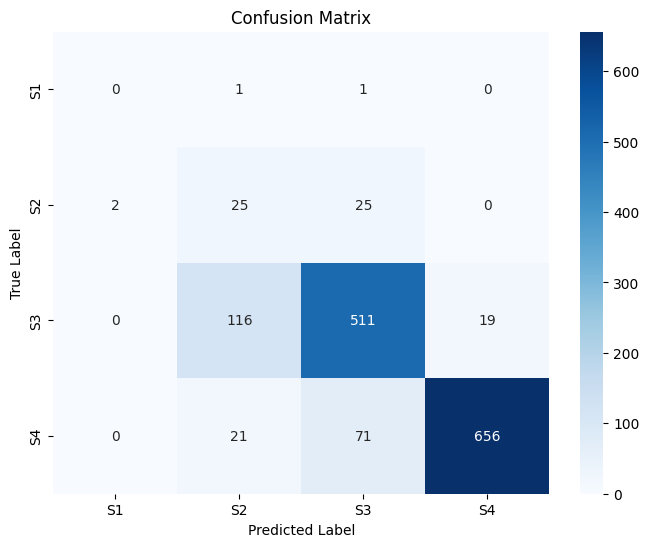

Specificity (per class): [0.9986168741355463, 0.9011461318051576, 0.8790523690773068, 0.9728571428571429]
Recall (per class): [0.0, 0.4807692307692308, 0.7910216718266254, 0.8770053475935828]
Precision (per class): [0.0, 0.15337423312883436, 0.8404605263157895, 0.9718518518518519]
F1-score (per class): [0, 0.23255813953488372, 0.8149920255183413, 0.9219957835558679]
AUC-ROC for class S1: 0.4993
AUC-ROC for class S2: 0.6910
AUC-ROC for class S3: 0.8350
AUC-ROC for class S4: 0.9249


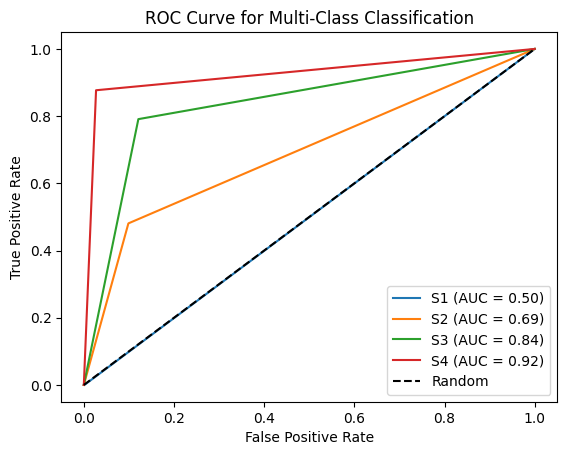

Accuracy: 0.5891
Confusion Matrix:
     S1   S2   S3   S4
S1    0    1    1    0
S2   12   14   26    0
S3  247  145  235   19
S4   48   15   81  604


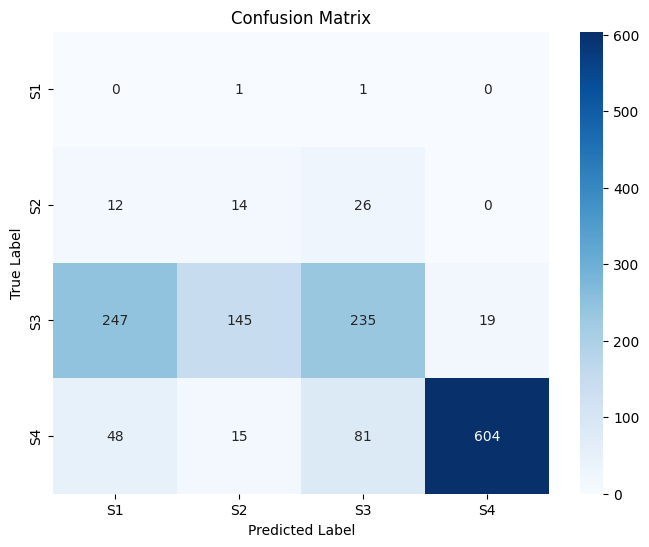

Specificity (per class): [0.7876901798063624, 0.8846704871060171, 0.8653366583541147, 0.9728571428571429]
Recall (per class): [0.0, 0.2692307692307692, 0.3637770897832817, 0.8074866310160428]
Precision (per class): [0.0, 0.08, 0.685131195335277, 0.9695024077046549]
F1-score (per class): [0, 0.12334801762114536, 0.4752275025278058, 0.8811086797957696]
AUC-ROC for class S1: 0.3938
AUC-ROC for class S2: 0.5770
AUC-ROC for class S3: 0.6146
AUC-ROC for class S4: 0.8902


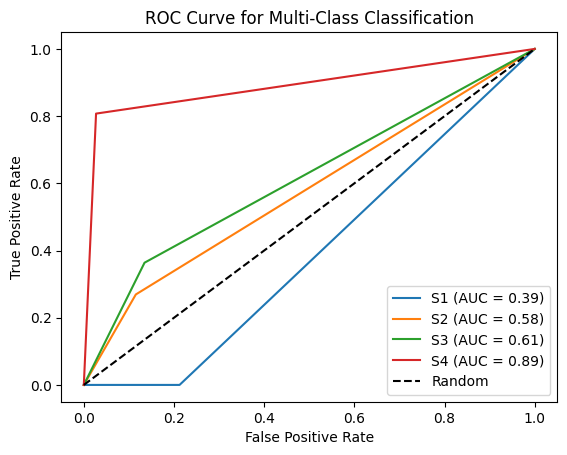

Accuracy: 0.8474
Confusion Matrix:
    S1  S2   S3   S4
S1   1   0    1    0
S2   2  21   29    0
S3   0  76  547   23
S4   2   9   79  658


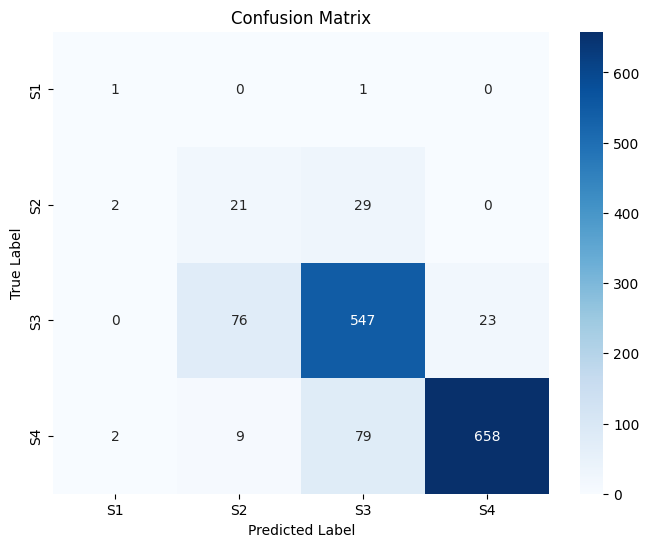

Specificity (per class): [0.9972337482710927, 0.9391117478510028, 0.8640897755610972, 0.9671428571428572]
Recall (per class): [0.5, 0.40384615384615385, 0.846749226006192, 0.8796791443850267]
Precision (per class): [0.2, 0.19811320754716982, 0.8338414634146342, 0.9662261380323054]
F1-score (per class): [0.28571428571428575, 0.2658227848101266, 0.8402457757296466, 0.9209237228831351]
AUC-ROC for class S1: 0.7486
AUC-ROC for class S2: 0.6715
AUC-ROC for class S3: 0.8554
AUC-ROC for class S4: 0.9234


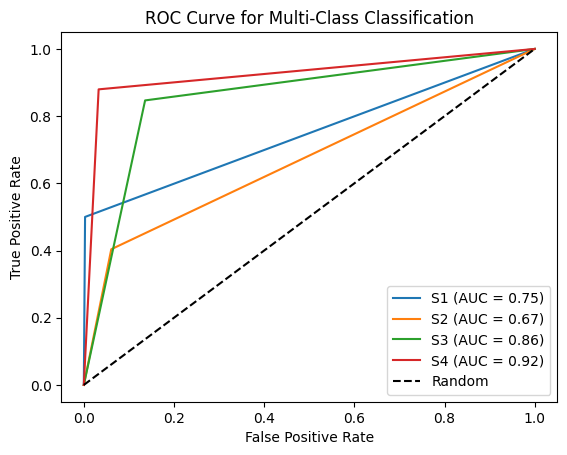

In [297]:
y_pred = run_gradient_boosting(resampled["X_ros"], resampled["y_ros"], X_test, y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

y_pred = run_gradient_boosting(resampled["X_rus"], resampled["y_rus"], X_test, y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

y_pred = run_gradient_boosting(resampled["X_smote"], resampled["y_smote"], resampled["X_test"], y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

# run_gradient_boosting(resampled["X_adasyn"], resampled["y_adasyn"], resampled["X_test"], y_test)
# run_gradient_boosting(resampled["X_smoteenn"], resampled["y_smoteenn"], resampled["X_test"], y_test)

Accuracy: 0.8888
Confusion Matrix:
    S1  S2   S3   S4
S1   0   0    2    0
S2   0   3   48    1
S3   0   2  612   32
S4   0   1   75  672


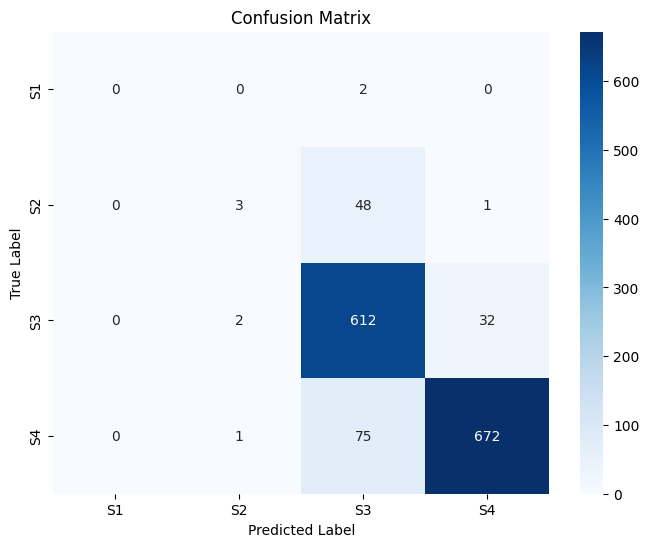

Specificity (per class): [1.0, 0.9978510028653295, 0.844139650872818, 0.9528571428571428]
Recall (per class): [0.0, 0.057692307692307696, 0.9473684210526315, 0.8983957219251337]
Precision (per class): [0, 0.5, 0.830393487109905, 0.9531914893617022]
F1-score (per class): [0, 0.10344827586206896, 0.8850325379609544, 0.9249827942188575]
AUC-ROC for class S1: 0.5000
AUC-ROC for class S2: 0.5278
AUC-ROC for class S3: 0.8958
AUC-ROC for class S4: 0.9256


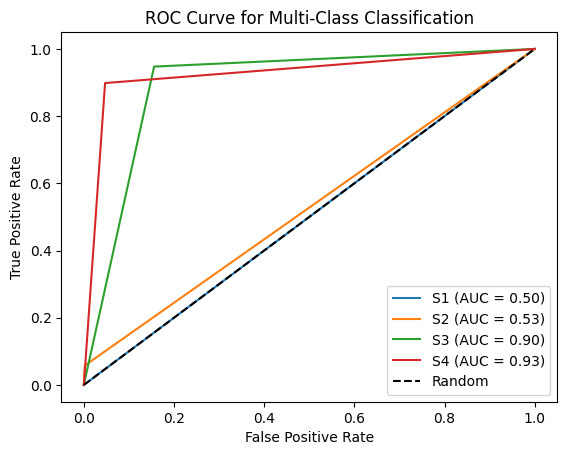

Accuracy: 0.6720
Confusion Matrix:
    S1   S2   S3   S4
S1   0    1    1    0
S2  14   11   27    0
S3  43  142  441   20
S4   8   21  198  521


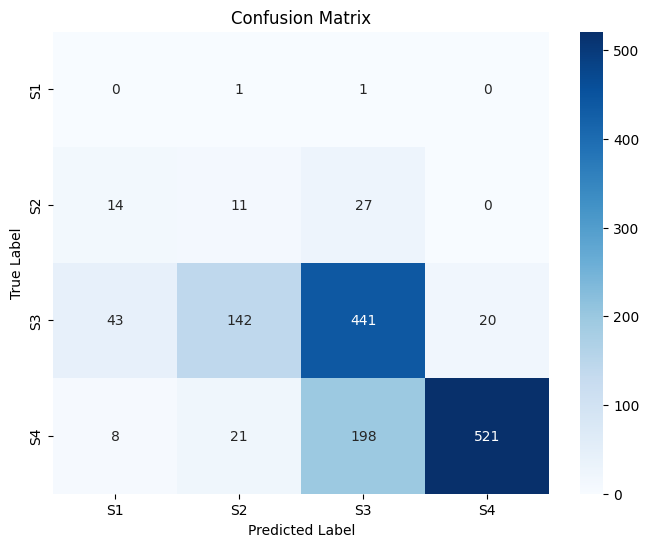

Specificity (per class): [0.9550484094052559, 0.8825214899713467, 0.7182044887780549, 0.9714285714285714]
Recall (per class): [0.0, 0.21153846153846154, 0.6826625386996904, 0.696524064171123]
Precision (per class): [0.0, 0.06285714285714286, 0.6611694152923538, 0.9630314232902033]
F1-score (per class): [0, 0.09691629955947137, 0.6717440974866717, 0.8083785880527541]
AUC-ROC for class S1: 0.4775
AUC-ROC for class S2: 0.5470
AUC-ROC for class S3: 0.7004
AUC-ROC for class S4: 0.8340


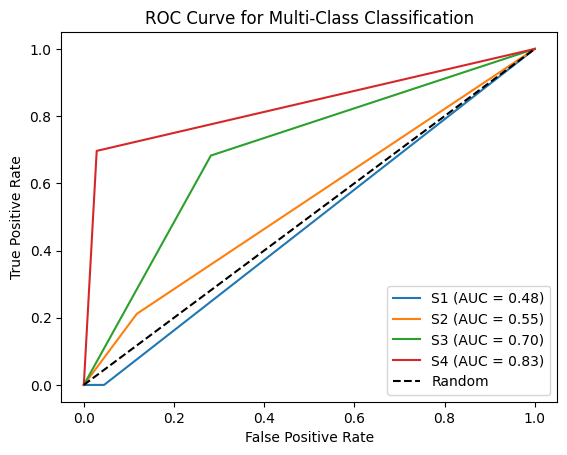

Accuracy: 0.8743
Confusion Matrix:
    S1  S2   S3   S4
S1   0   0    2    0
S2   0   9   42    1
S3   3  26  589   28
S4   0   7   73  668


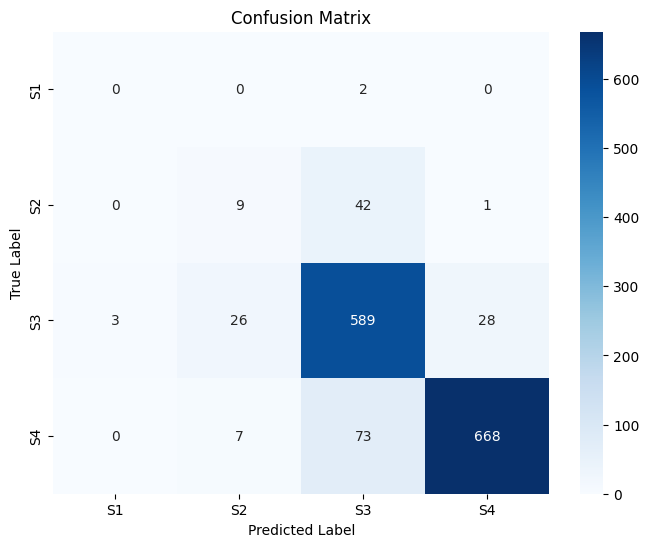

Specificity (per class): [0.9979253112033195, 0.9763610315186246, 0.8541147132169576, 0.9585714285714285]
Recall (per class): [0.0, 0.17307692307692307, 0.9117647058823529, 0.893048128342246]
Precision (per class): [0.0, 0.21428571428571427, 0.8342776203966006, 0.9583931133428981]
F1-score (per class): [0, 0.1914893617021277, 0.8713017751479291, 0.9245674740484429]
AUC-ROC for class S1: 0.4990
AUC-ROC for class S2: 0.5747
AUC-ROC for class S3: 0.8829
AUC-ROC for class S4: 0.9258


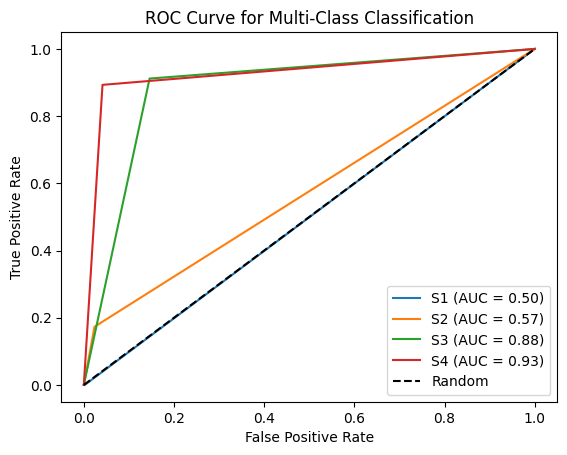

In [310]:
y_pred = run_et(resampled["X_ros"], resampled["y_ros"], X_test, y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

y_pred = run_et(resampled["X_rus"], resampled["y_rus"], X_test, y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

y_pred = run_et(resampled["X_smote"], resampled["y_smote"], resampled["X_test"], y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

# run_xgboost(resampled["X_adasyn"], resampled["y_adasyn"], resampled["X_test"], y_test)
# run_xgboost(resampled["X_smoteenn"], resampled["y_smoteenn"], resampled["X_test"], y_test)

Accuracy: 0.8550
Confusion Matrix:
    S1  S2   S3   S4
S1   0   0    1    1
S2   0  14   37    1
S3   1  43  544   58
S4   0   5   63  680


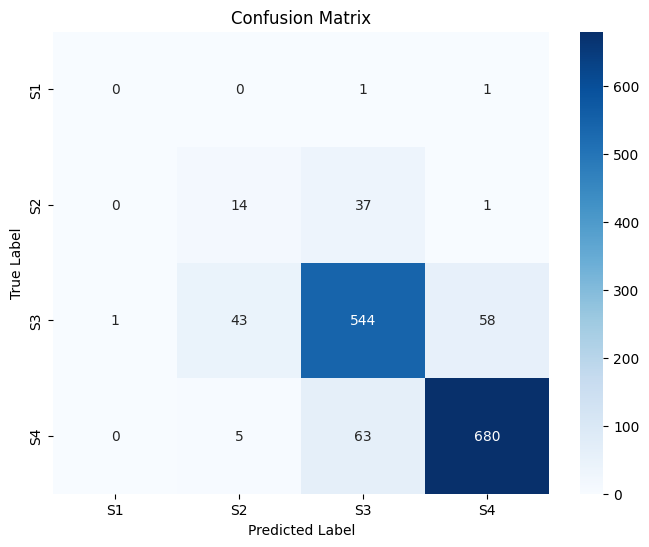

Specificity (per class): [0.9993084370677732, 0.9656160458452722, 0.8740648379052369, 0.9142857142857143]
Recall (per class): [0.0, 0.2692307692307692, 0.8421052631578947, 0.9090909090909091]
Precision (per class): [0.0, 0.22580645161290322, 0.8434108527131783, 0.918918918918919]
F1-score (per class): [0, 0.2456140350877193, 0.8427575522850503, 0.9139784946236559]
AUC-ROC for class S1: 0.4997
AUC-ROC for class S2: 0.6174
AUC-ROC for class S3: 0.8581
AUC-ROC for class S4: 0.9117


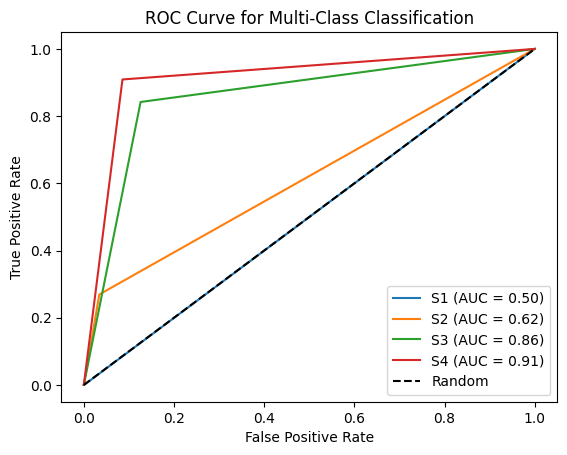

Accuracy: 0.7638
Confusion Matrix:
    S1   S2   S3   S4
S1   0    1    1    0
S2   5   12   35    0
S3  33  125  475   13
S4   3   15  111  619


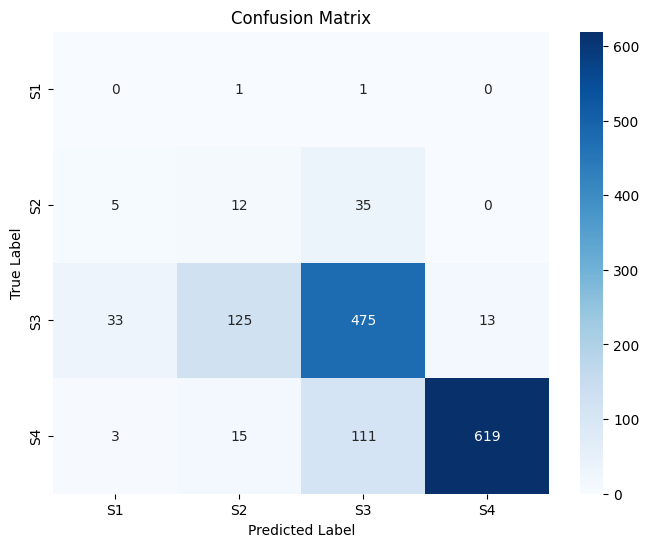

Specificity (per class): [0.9716459197786999, 0.8989971346704871, 0.816708229426434, 0.9814285714285714]
Recall (per class): [0.0, 0.23076923076923078, 0.7352941176470589, 0.8275401069518716]
Precision (per class): [0.0, 0.0784313725490196, 0.7636655948553055, 0.9794303797468354]
F1-score (per class): [0, 0.11707317073170732, 0.749211356466877, 0.8971014492753623]
AUC-ROC for class S1: 0.4858
AUC-ROC for class S2: 0.5649
AUC-ROC for class S3: 0.7760
AUC-ROC for class S4: 0.9045


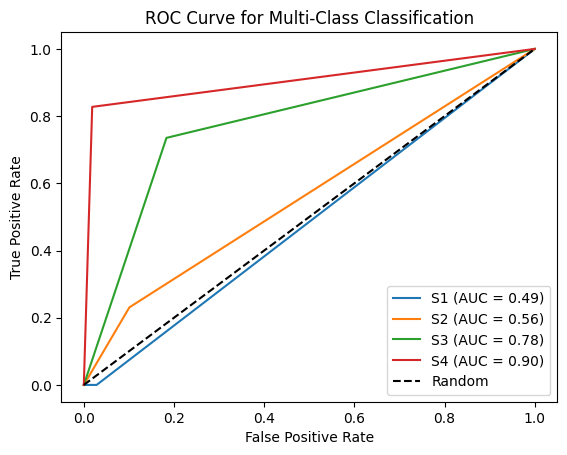

Accuracy: 0.8349
Confusion Matrix:
    S1  S2   S3   S4
S1   0   0    2    0
S2   0  15   36    1
S3   5  66  521   54
S4   0   7   68  673


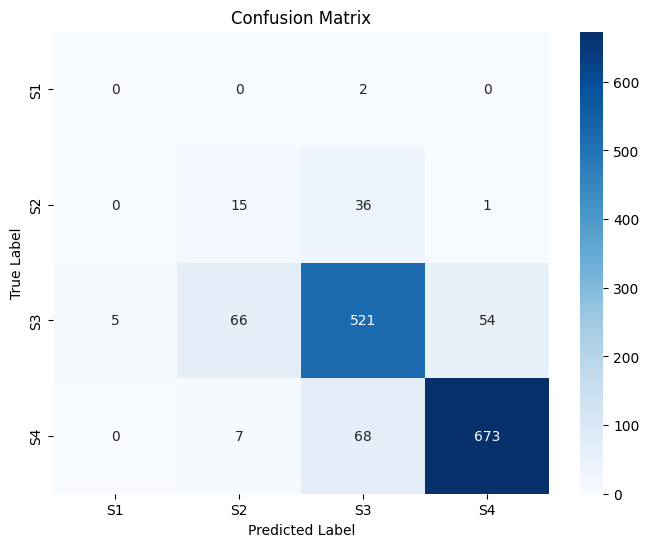

Specificity (per class): [0.9965421853388658, 0.9477077363896849, 0.8678304239401496, 0.9214285714285714]
Recall (per class): [0.0, 0.28846153846153844, 0.8065015479876161, 0.8997326203208557]
Precision (per class): [0.0, 0.17045454545454544, 0.8309409888357256, 0.9244505494505495]
F1-score (per class): [0, 0.21428571428571427, 0.8185388845247447, 0.9119241192411925]
AUC-ROC for class S1: 0.4983
AUC-ROC for class S2: 0.6181
AUC-ROC for class S3: 0.8372
AUC-ROC for class S4: 0.9106


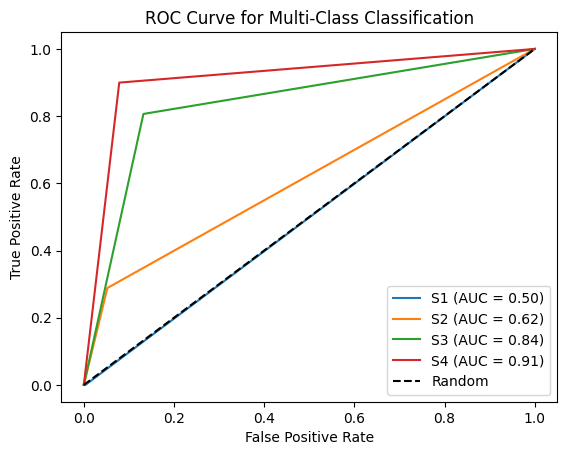

In [318]:
y_pred = run_dt(resampled["X_ros"], resampled["y_ros"], X_test, y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

y_pred = run_dt(resampled["X_rus"], resampled["y_rus"], X_test, y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

y_pred = run_dt(resampled["X_smote"], resampled["y_smote"], resampled["X_test"], y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

# run_dt(resampled["X_adasyn"], resampled["y_adasyn"], resampled["X_test"], y_test)
# run_dt(resampled["X_smoteenn"], resampled["y_smoteenn"], resampled["X_test"], y_test)

In [ ]:
y_pred = run_mlp(resampled["X_ros"], resampled["y_ros"], X_test, y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

y_pred = run_mlp(resampled["X_rus"], resampled["y_rus"], X_test, y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

y_pred = run_mlp(resampled["X_smote"], resampled["y_smote"], resampled["X_test"], y_test)
calculate_metrics(y_test, y_pred, class_names=class_names)

# run_catboost(resampled["X_adasyn"], resampled["y_adasyn"], resampled["X_test"], y_test)
# run_catboost(resampled["X_smoteenn"], resampled["y_smoteenn"], resampled["X_test"], y_test)

# Heatmap

In [ ]:
# mergeddataS = dmergeddata
mergeddataS = dmergeddata[dmergeddata.columns.drop(list(dmergeddata.filter(regex='^Psummary')))]
mergeddataS = mergeddataS[mergeddataS.columns.drop(list(mergeddataS.filter(regex='^component')))]
mergeddataS = mergeddataS.drop(['product_Core','classification_Components'],axis=1)
mergeddataP = dmergeddata[list(dmergeddata.filter(regex='^Psummary'))]

In [ ]:
print(mergeddataS.columns.tolist())
print(mergeddataP.columns.tolist())

['id', 'severity', 'version', 'assigned_to_detail.id', 'resolution_', 'resolution_DUPLICATE', 'resolution_FIXED', 'resolution_INCOMPLETE', 'resolution_INVALID', 'resolution_WONTFIX', 'resolution_WORKSFORME', 'type_defect', 'type_enhancement', 'type_task']
['Psummary_intermittent', 'Psummary_bug', 'Psummary_tracking', 'Psummary_single', 'Psummary_sync', 'Psummary_pr', 'Psummary_wptsync', 'Psummary_test', 'Psummary_wpt', 'Psummary_tier', 'Psummary_failure', 'Psummary_add', 'Psummary_crash', 'Psummary_firefox', 'Psummary_code', 'Psummary_new', 'Psummary_remove', 'Psummary_fix', 'Psummary_update', 'Psummary_failing', 'Psummary_args', 'Psummary_assertion', 'Psummary_nt', 'Psummary_http', 'Psummary_implement', 'Psummary_support', 'Psummary_unknown', 'Psummary_window', 'Psummary_mozilla', 'Psummary_use', 'Psummary_video', 'Psummary_page', 'Psummary_error', 'Psummary_set', 'Psummary_meta', 'Psummary_text', 'Psummary_perma', 'Psummary_using', 'Psummary_element', 'Psummary_file', 'Psummary_work'

In [ ]:
summary.drop(axis=1, columns=['Unnamed: 0','nindex','index'], inplace=True)
summary.head()

data['Psummary']=data['Psummary'].tolist()

data['Pdescription']=data['Pdescription'].apply(lambda x: ' '.join(x))
data['Psummary']=data['Psummary'].apply(lambda x: ' '.join(x))


from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf(df,col):
    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform(df[col])

    # Select the first five documents from the data set
    tf_idf = pd.DataFrame(vectors.todense())#.iloc[:5]
    tf_idf.columns = vectorizer.get_feature_names_out()
    tfidf_matrix = tf_idf.T
    tfidf_matrix.columns = ['bug'+ str(i) for i in range(1, 10001)]
    tfidf_matrix['count'] = tfidf_matrix.sum(axis=1)

    # Top words
    tfidf_matrix = tfidf_matrix.sort_values(by ='count', ascending=False)

    # Print the first 10 words
    # print(tfidf_matrix.drop(columns=['count']).head(10))

    return tfidf_matrix

# tfidf_Pdescription = tfidf(data,'Pdescription')
tfidf_Psummary = tfidf(data,'Psummary')
over1 = tfidf_Psummary.loc[tfidf_Psummary['count']>1]

filter='^\d+$'
notfilter='^(?!'+filter+').*$'
wordlst = over1.loc[over1.index.str.contains(notfilter)]

wordlst['words'] = 'Psummary_' + wordlst.index.astype(str)
wordlst.head()

summary = summary[wordlst['words']]
summary.head()

mergeddata = pd.concat([data,summary],axis=1)

mergeddata.to_csv('dataset_20240907_plusP_Psummary_tfidf_10.csv')

In [ ]:
# Assuming you have your DataFrame loaded as 'dataHM'

# Get all columns
all_columns = mergeddataS.columns.tolist()

# Get numerical columns
numerical_columns = mergeddataS.select_dtypes(include=['number']).columns.tolist()

# Get non-numerical columns
non_numerical_columns = list(set(all_columns) - set(numerical_columns))

print("Columns that cannot be converted to float:", non_numerical_columns)

Columns that cannot be converted to float: ['resolution', 'status', 'creation_time', 'last_change_time', 'classification', 'component', 'type', 'product']


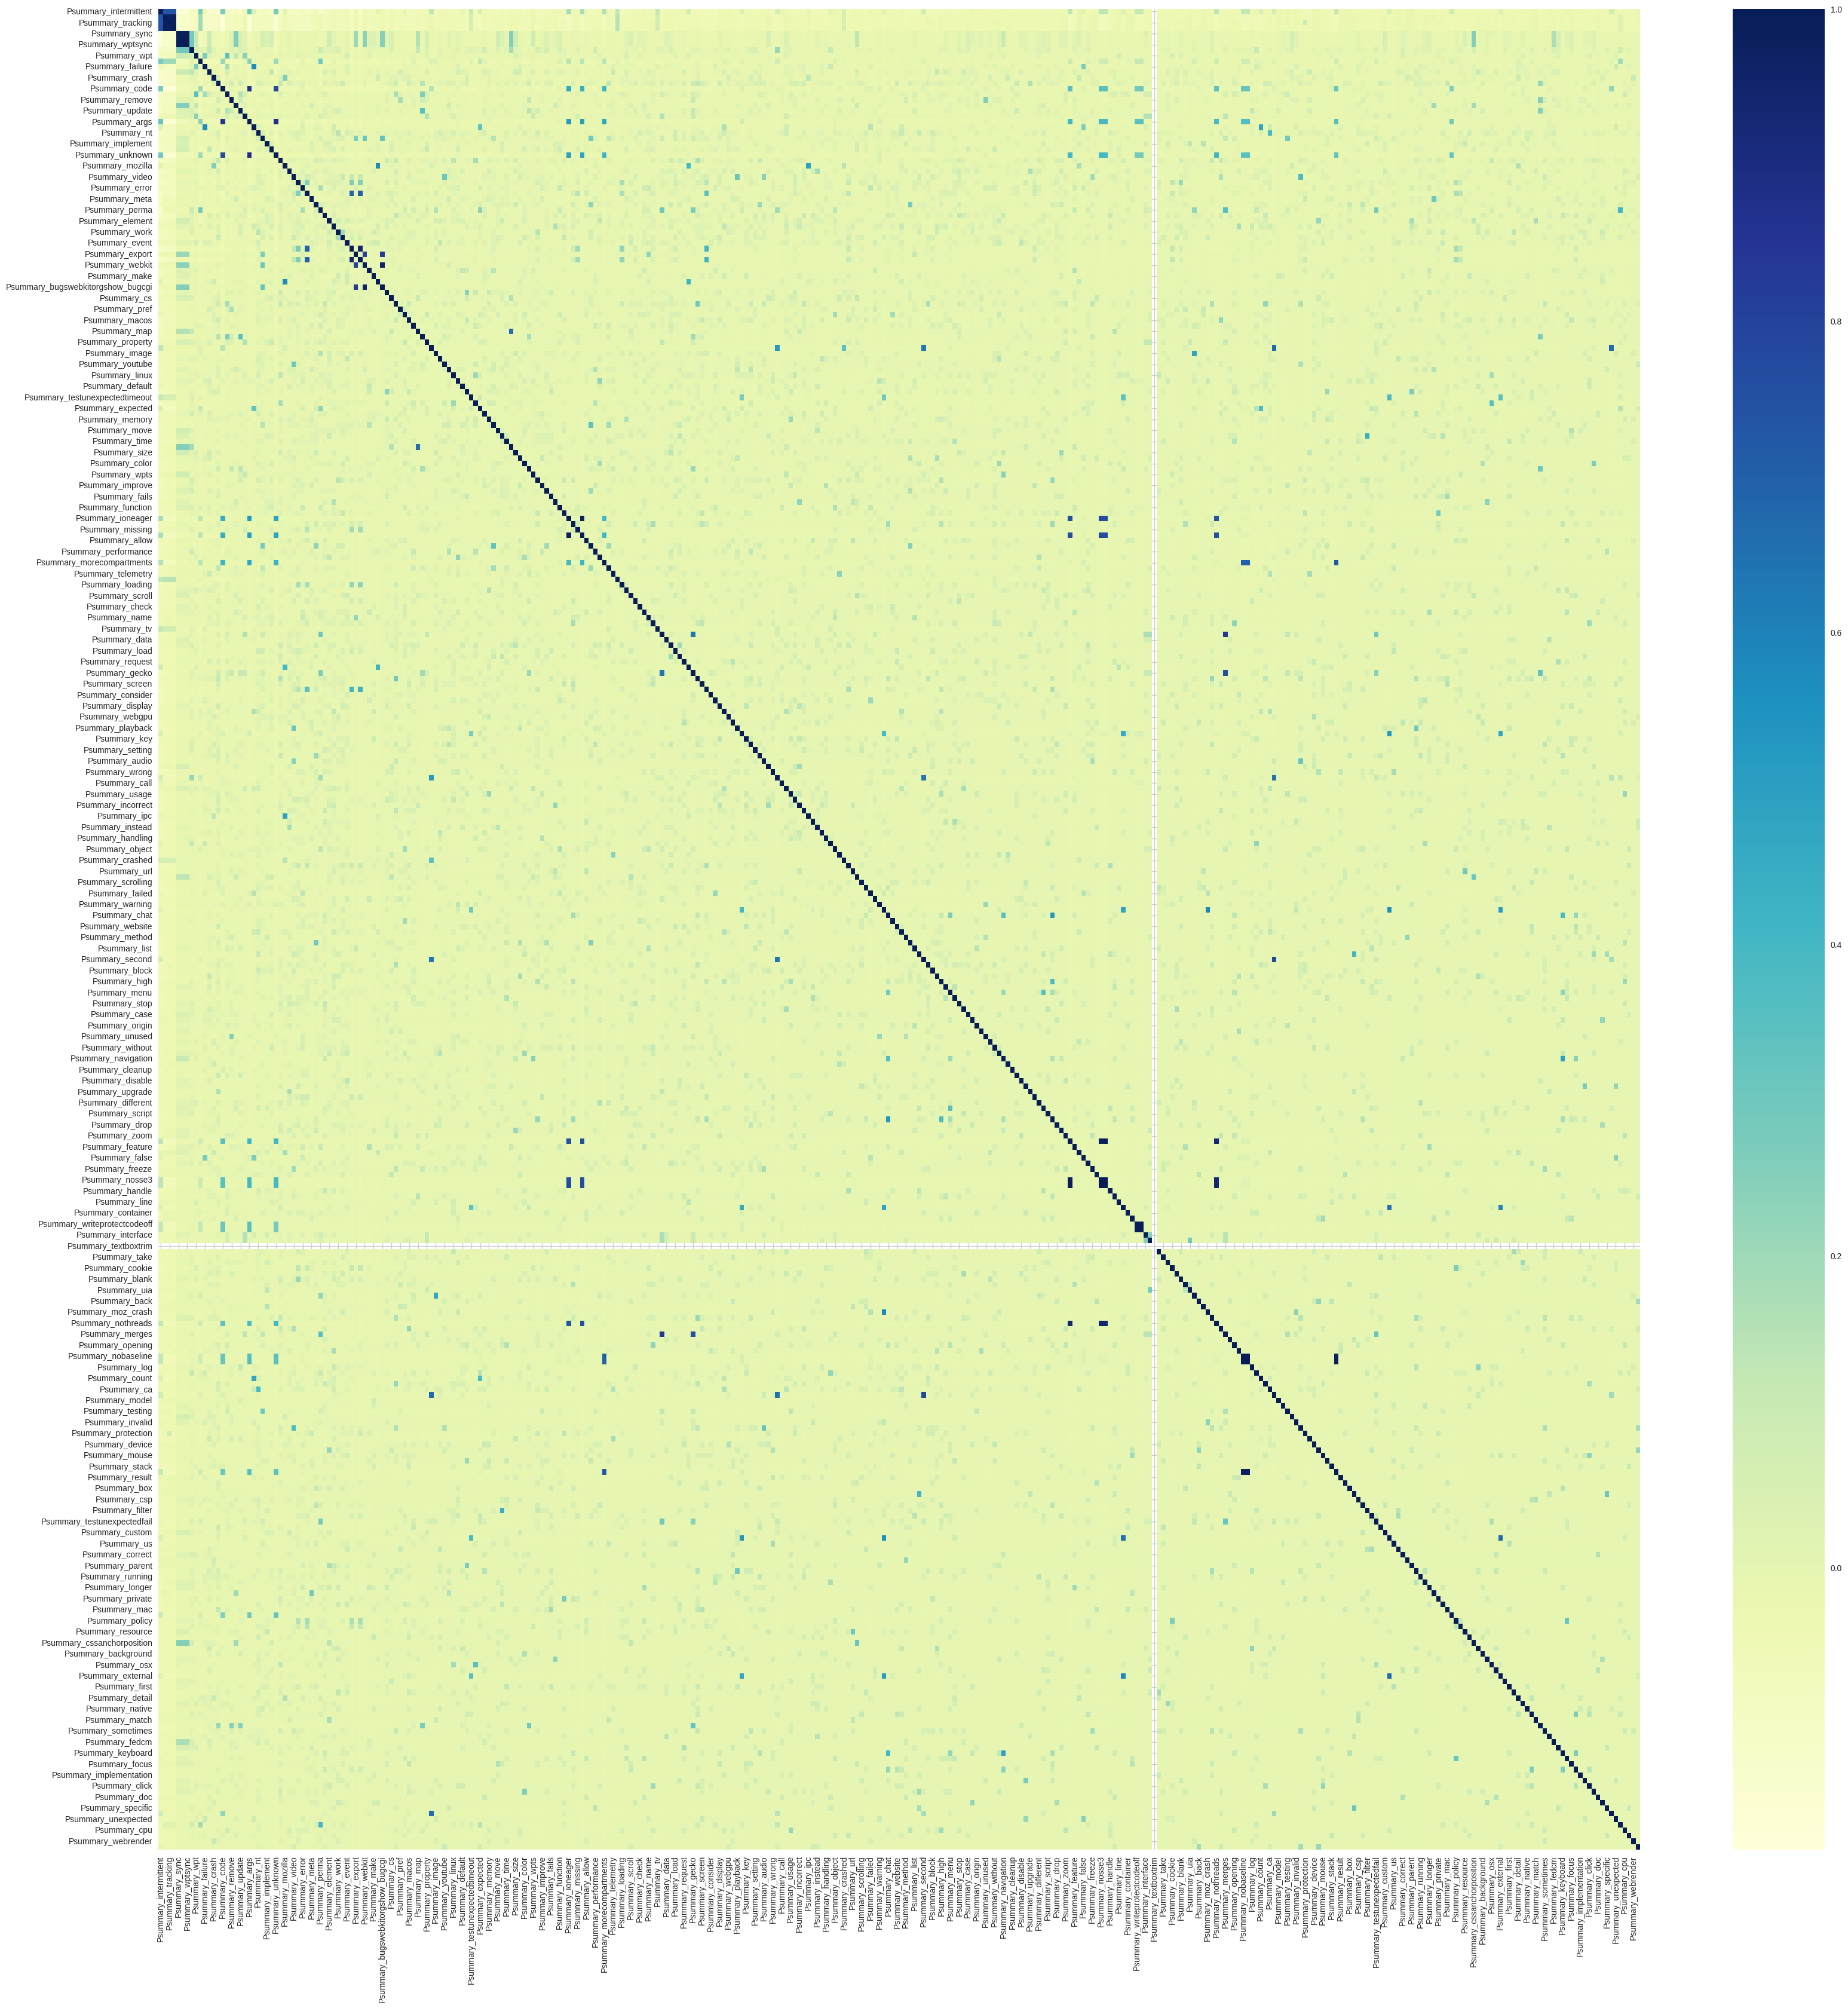

In [ ]:
# Import modules
import matplotlib.pyplot as mp
import pandas as pd
import seaborn as sb

# Import file with data
dataHM = mergeddataP.copy()
# mergeddata[mergeddata.columns.drop(list(mergeddata.filter(regex='^Psummary')))]

# Print data that will be plotted
# Columns shown here are selected by corr() since
# they are ideal for the plot
# print(dataHM.corr(numeric_only=True))

# Plotting correlation heatmap
fig, ax = mp.subplots(figsize=(40, 40))
dataplot = sb.heatmap(dataHM.corr(numeric_only=True), cmap="YlGnBu", annot=False, ax=ax)

# Displaying heatmap
mp.show()


In [ ]:
threshold = 0.005
correlations = mergeddataS.corr()['severity'].abs().sort_values(ascending=False)
selected_features = correlations[correlations > threshold].index  # Set a threshold
print(correlations)
print(selected_features)
mergeddata = mergeddataS[selected_features]

severity                 1.000000
type_defect              0.457767
type_task                0.373556
version                  0.350471
type_enhancement         0.216913
resolution_INCOMPLETE    0.115843
resolution_WORKSFORME    0.076393
resolution_              0.067771
id                       0.062608
resolution_INVALID       0.055402
resolution_WONTFIX       0.040366
resolution_DUPLICATE     0.017682
assigned_to_detail.id    0.010912
resolution_FIXED         0.006552
Name: severity, dtype: float64
Index(['severity', 'type_defect', 'type_task', 'version', 'type_enhancement',
       'resolution_INCOMPLETE', 'resolution_WORKSFORME', 'resolution_', 'id',
       'resolution_INVALID', 'resolution_WONTFIX', 'resolution_DUPLICATE',
       'assigned_to_detail.id', 'resolution_FIXED'],
      dtype='object')


In [ ]:
threshold = 0.005
mergeddataP['severity'] = mergeddataS['severity']
correlations = mergeddataP.corr()['severity'].abs().sort_values(ascending=False)
selected_features = correlations[correlations > threshold].index  # Set a threshold
print(correlations)
print(selected_features)
mergeddata = pd.concat([mergeddata,mergeddataP[selected_features]])

severity                 1.000000
Psummary_intermittent    0.131275
Psummary_crash           0.126663
Psummary_strict          0.125892
Psummary_etp             0.117092
                           ...   
Psummary_time            0.000342
Psummary_gc              0.000163
Psummary_expose          0.000147
Psummary_custom          0.000104
Psummary_textboxtrim          NaN
Name: severity, Length: 335, dtype: float64
Index(['severity', 'Psummary_intermittent', 'Psummary_crash',
       'Psummary_strict', 'Psummary_etp', 'Psummary_probe', 'Psummary_page',
       'Psummary_set', 'Psummary_video', 'Psummary_displayed',
       ...
       'Psummary_wb', 'Psummary_policy', 'Psummary_thread',
       'Psummary_function', 'Psummary_call', 'Psummary_second',
       'Psummary_beta', 'Psummary_message', 'Psummary_instead',
       'Psummary_issue'],
      dtype='object', length=301)


In [ ]:
mergeddata.columns.tolist()

['severity',
 'type_defect',
 'type_task',
 'version',
 'type_enhancement',
 'resolution_INCOMPLETE',
 'resolution_WORKSFORME',
 'resolution_',
 'id',
 'resolution_INVALID',
 'resolution_WONTFIX',
 'resolution_DUPLICATE',
 'assigned_to_detail.id',
 'resolution_FIXED',
 'Psummary_intermittent',
 'Psummary_crash',
 'Psummary_strict',
 'Psummary_etp',
 'Psummary_probe',
 'Psummary_page',
 'Psummary_set',
 'Psummary_video',
 'Psummary_displayed',
 'Psummary_single',
 'Psummary_tracking',
 'Psummary_bug',
 'Psummary_add',
 'Psummary_enabled',
 'Psummary_keyboard',
 'Psummary_meta',
 'Psummary_button',
 'Psummary_nt',
 'Psummary_telemetry',
 'Psummary_remove',
 'Psummary_failure',
 'Psummary_sidebar',
 'Psummary_code',
 'Psummary_firefox',
 'Psummary_element',
 'Psummary_window',
 'Psummary_mac',
 'Psummary_loading',
 'Psummary_does_not',
 'Psummary_navigation',
 'Psummary_string',
 'Psummary_stop',
 'Psummary_macos',
 'Psummary_chat',
 'Psummary_scroll',
 'Psummary_audio',
 'Psummary_script

In [ ]:
from pycaret.classification import *

data = mergeddata

clf1 = setup(data.reset_index(drop=True), target='severity')

model = [create_model(i) for i in [
    'rf',
    'gbc',
    'et',
    'xgboost',
    'catboost',
    'lightgbm',
    'dt']]

for i in (range(7)):
    print(i)
    model[i].get_params()

,Description,Value
0,Session id,7695
1,Target,severity
2,Target type,Multiclass
3,Original data shape,"(8218, 69)"
4,Transformed data shape,"(8218, 69)"
5,Transformed train set shape,"(5752, 69)"
6,Transformed test set shape,"(2466, 69)"
7,Numeric features,58
8,Categorical features,10
9,Rows with missing values,100.0%


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6736,0.8473,0.6736,0.6864,0.6766,0.4765,0.4793
1,0.7240,0.8711,0.7240,0.7304,0.7222,0.5562,0.5610
2,0.6539,0.0000,0.6539,0.6750,0.6564,0.4467,0.4523
3,0.7061,0.0000,0.7061,0.7137,0.7048,0.5255,0.5302
4,0.6974,0.0000,0.6974,0.7076,0.6983,0.5134,0.5173
5,0.6904,0.0000,0.6904,0.7036,0.6902,0.5006,0.5067
6,0.7078,0.8618,0.7078,0.7196,0.7057,0.5265,0.5328
7,0.7043,0.8767,0.7043,0.7078,0.7032,0.5227,0.5252
8,0.6817,0.8465,0.6817,0.6973,0.6833,0.4920,0.4970


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7118,0.0000,0.7118,0.7153,0.7094,0.5344,0.5383
1,0.7587,0.0000,0.7587,0.7567,0.7544,0.6107,0.6143
2,0.6991,0.0000,0.6991,0.7101,0.6999,0.5207,0.5258
3,0.7217,0.0000,0.7217,0.7221,0.7194,0.5494,0.5517
4,0.7026,0.0000,0.7026,0.7191,0.7047,0.5280,0.5346
5,0.7130,0.0000,0.7130,0.7265,0.7140,0.5428,0.5490
6,0.7096,0.0000,0.7096,0.7241,0.7086,0.5316,0.5392
7,0.7391,0.0000,0.7391,0.7574,0.7365,0.5766,0.5795
8,0.7130,0.0000,0.7130,0.7236,0.7133,0.5433,0.5486


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6684,0.8277,0.6684,0.6875,0.6733,0.4706,0.4743
1,0.7257,0.8492,0.7257,0.7306,0.7231,0.5580,0.5628
2,0.6574,0.0000,0.6574,0.6756,0.6595,0.4529,0.4582
3,0.6904,0.0000,0.6904,0.7028,0.6911,0.5017,0.5067
4,0.6748,0.0000,0.6748,0.6977,0.6813,0.4816,0.4857
5,0.6904,0.0000,0.6904,0.7068,0.6922,0.5022,0.5078
6,0.6957,0.8578,0.6957,0.7173,0.6974,0.5103,0.5176
7,0.7009,0.8664,0.7009,0.7109,0.7019,0.5183,0.5216
8,0.6887,0.8356,0.6887,0.7074,0.6915,0.5047,0.5106


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7118,0.8684,0.7118,0.7102,0.7079,0.5320,0.5348
1,0.7500,0.8991,0.7500,0.7425,0.7438,0.5941,0.5967
2,0.6957,0.0000,0.6957,0.7068,0.6959,0.5120,0.5153
3,0.7235,0.0000,0.7235,0.7218,0.7192,0.5492,0.5521
4,0.6974,0.0000,0.6974,0.7157,0.6983,0.5166,0.5249
5,0.7183,0.0000,0.7183,0.7295,0.7182,0.5483,0.5542
6,0.7096,0.8728,0.7096,0.7236,0.7088,0.5293,0.5354
7,0.7391,0.8959,0.7391,0.7376,0.7348,0.5770,0.5806
8,0.7200,0.8777,0.7200,0.7302,0.7197,0.5509,0.5545


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7188,0.8723,0.7188,0.7099,0.7127,0.5425,0.5442
1,0.7552,0.9012,0.7552,0.7429,0.7471,0.6008,0.6028
2,0.6957,0.0000,0.6957,0.6973,0.6935,0.5115,0.5148
3,0.7322,0.0000,0.7322,0.7275,0.7273,0.5640,0.5665
4,0.6991,0.0000,0.6991,0.7072,0.6986,0.5176,0.5224
5,0.7096,0.0000,0.7096,0.7182,0.7088,0.5336,0.5389
6,0.7078,0.8795,0.7078,0.7166,0.7052,0.5244,0.5299
7,0.7322,0.8939,0.7322,0.7256,0.7266,0.5640,0.5663
8,0.7113,0.8809,0.7113,0.7119,0.7087,0.5361,0.5392


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7049,0.8645,0.7049,0.7067,0.7034,0.5234,0.5255
1,0.7483,0.8938,0.7483,0.7421,0.7433,0.5914,0.5932
2,0.6991,0.0000,0.6991,0.7232,0.7004,0.5170,0.5200
3,0.7357,0.0000,0.7357,0.7351,0.7311,0.5700,0.5738
4,0.7113,0.0000,0.7113,0.7239,0.7117,0.5362,0.5418
5,0.7148,0.0000,0.7148,0.7282,0.7155,0.5437,0.5498
6,0.7078,0.8706,0.7078,0.7190,0.7056,0.5250,0.5307
7,0.7443,0.8895,0.7443,0.7475,0.7417,0.5878,0.5921
8,0.7096,0.8769,0.7096,0.7242,0.7098,0.5348,0.5402


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6667,0.7832,0.6667,0.6846,0.6717,0.4667,0.4696
1,0.7205,0.7997,0.7205,0.7357,0.7217,0.5506,0.5557
2,0.6557,0.0000,0.6557,0.6741,0.6593,0.4518,0.4566
3,0.6887,0.0000,0.6887,0.7022,0.6902,0.4976,0.5019
4,0.6800,0.0000,0.6800,0.7063,0.6859,0.4905,0.4965
5,0.6957,0.0000,0.6957,0.7166,0.6999,0.5114,0.5163
6,0.6870,0.8107,0.6870,0.7062,0.6885,0.4934,0.4988
7,0.6904,0.8078,0.6904,0.7049,0.6935,0.5033,0.5068
8,0.6887,0.8023,0.6887,0.7044,0.6907,0.5020,0.5071


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

0
1
2
3
4
5
6


# Something else

In [ ]:
data = dummies(data,'component')
# data, lemodel = lencoder(data,'priority')
data, lemodel = lencoder(data,'severity')
data, lemodel = lencoder(data,'version')
# data['creation_time'] = pd.to_datetime(data['creation_time'])
# data['last_change_time'] = pd.to_datetime(data['last_change_time'])
data['assigned_to_detail.id'] = data['assigned_to_detail.id']

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer # Import TF-IDF vectorizer

# 1. Prepare Data
X = data.drop(['severity',
               'component',
                'status'
               ],axis=1)
               # Target variable
                # 'priority', 'resolution', 'product', 'creation_time',
                # 'classification', 'type', 'last_change_time',
                #'assigned_to', 'assigned_to_detail.nick',
                # 'assigned_to_detail.name', 'assigned_to_detail.email'],
Y = dataset['severity']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=7)

# Assuming 'Pdescription' column contains the text data
text_column = 'Pdescription'

# 2. Create TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# 3. Fit and Transform Training Data
X_train_text = vectorizer.fit_transform(X_train[text_column].astype(str)) # Convert to string if necessary

# 4. Transform Test Data
X_test_text = vectorizer.transform(X_test[text_column].astype(str))

# 5. Replace Text Column with TF-IDF Features in X_train and X_test
X_train = X_train.drop(text_column, axis=1)
X_train_text_df = pd.DataFrame(X_train_text.toarray())
X_train_text_df.columns = [f'tfidf_{i}' for i in range(X_train_text_df.shape[1])] # Give string column names to TF-IDF features
X_train = pd.concat([X_train, X_train_text_df], axis=1)

X_test = X_test.drop(text_column, axis=1)
X_test_text_df = pd.DataFrame(X_test_text.toarray())
X_test_text_df.columns = [f'tfidf_{i}' for i in range(X_test_text_df.shape[1])] # Give string column names to TF-IDF features
X_test = pd.concat([X_test, X_test_text_df], axis=1)

# Ensure all column names are strings
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# 6. Train Random Forest
rf_model = RandomForestClassifier(n_estimators=5, random_state=7)
rf_model.fit(X_train, y_train)

# 3. Generate Pseudo-Labels
rf_probs = rf_model.predict_proba(X_test)
pseudo_labels = [np.argmax(prob) if max(prob) > 0.8 else -1 for prob in rf_probs]

# 4. Combine Data
X_combined = pd.concat([X_train, X_test])
y_combined = pd.concat([y_train, pd.Series(pseudo_labels)])
mask = y_combined != -1
X_combined = X_combined[mask]
y_combined = y_combined[mask]

# Ensure all column names in X_combined are strings
X_combined.columns = X_combined.columns.astype(str)


# 5. Train LightGBM
lgbm_model = LGBMClassifier(n_estimators=100, random_state=7)
lgbm_model.fit(X_combined, y_combined)

# Evaluation
y_pred = lgbm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")